# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

***

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

# Создаем подключение
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}
conn = psycopg2.connect(**pg_connection)

## 1. Обзор данных
***

### 1.1. Рассмотрим какие таблицы представлены в БД
***

In [2]:
# Рассмотрим какие таблицы представлены в базе
cursor = conn.cursor()

# получаем имена таблиц из базы
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"
cursor.execute(sql_str)
tables_data = [a for a in cursor.fetchall()]
conn.commit()

print("Таблицы содержащиеся в Postgres: %s" % tables_data)

Таблицы содержащиеся в Postgres: [('hr_dataset',), ('production_staff',), ('recruiting_costs',), ('salary_grid',), ('tmpDB',)]


In [3]:
cursor = conn.cursor()

#### 1.1.1. Обзор "hr_dataset"

Выведем первые 5 строк таблицы для наглядного представления о данных.

In [4]:
# Создадим запрос к базе и выведем информацию в табличной форме для удобства чтения
sql_str = "SELECT * FROM hr_dataset limit 5;"
cursor.execute(sql_str)
hr_dataset_preview = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

hr_dataset_preview = pd.DataFrame(hr_dataset_preview, columns=field_names)
hr_dataset_preview.head()

,id,Employee Name,Employee Number,marriedid,maritalstatusid,genderid,empstatus_id,deptid,perf_scoreid,age,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,department,position,Manager Name,Employee Source,Performance Score
0,1,"Brown, Mia",1103024456,1,1,0,1,1,3,30,...,2008-10-27,3317,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,2,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,...,2014-01-06,1420,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,3,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,...,2014-09-29,1154,None,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,4,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,...,2015-02-16,58,2015-04-15,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,5,"Singh, Nan",1307059817,0,0,0,1,1,9,30,...,2015-05-01,940,None,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review


Получим всю информацию по столбцам таблицы. Названия и типы представленных данных

In [5]:
sql_str = """select column_name, data_type, character_maximum_length, column_default, is_nullable
from INFORMATION_SCHEMA.COLUMNS where table_name = 'hr_dataset';"""

cursor.execute(sql_str)
hr_dataset_desc = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

hr_dataset_desc = pd.DataFrame(hr_dataset_desc, columns=field_names)
hr_dataset_desc.head(30)

,column_name,data_type,character_maximum_length,column_default,is_nullable
0,id,integer,NaN,None,NO
1,Employee Name,character varying,50.0,None,YES
2,Employee Number,integer,NaN,None,YES
3,marriedid,integer,NaN,None,YES
4,maritalstatusid,integer,NaN,None,YES
5,genderid,integer,NaN,None,YES
6,empstatus_id,integer,NaN,None,YES
7,deptid,integer,NaN,None,YES
8,perf_scoreid,integer,NaN,None,YES
9,age,integer,NaN,None,YES


Рассмотрим какие существуют статусы работника:

In [6]:
sql_str = """SELECT DISTINCT "Employment Status" FROM hr_dataset;"""

cursor.execute(sql_str)
emp_status = cursor.fetchall()
emp_status

[('Future Start',),
 ('Voluntarily Terminated',),
 ('Active',),
 ('Terminated for Cause',),
 ('Leave of Absence',)]

Рассмотрим какие существуют причины увольнения:

In [7]:
sql_str = """SELECT DISTINCT "Reason For Term" FROM hr_dataset;"""

cursor.execute(sql_str)
Reason_For_Term = cursor.fetchall()
Reason_For_Term

[('N/A - Has not started yet',),
 ('attendance',),
 ('more money',),
 ('medical issues',),
 ('maternity leave - did not return',),
 ('return to school',),
 ('relocation out of area',),
 ('performance',),
 ('gross misconduct',),
 ('military',),
 ('hours',),
 ('career change',),
 ('unhappy',),
 ('retiring',),
 ('Another position',),
 ('no-call, no-show',),
 ('N/A - still employed',)]

Какие существуют департаменты в компании:

In [8]:
sql_str = """SELECT DISTINCT "department" FROM hr_dataset;"""

cursor.execute(sql_str)
dep = cursor.fetchall()
dep

[('Production       ',),
 ('Admin Offices',),
 ('IT/IS',),
 ('Executive Office',),
 ('Software Engineering',),
 ('Sales',)]

Количество строк

In [9]:
# Создаем запрос на подсчет строк
sql_str = """Select count('id') as size from hr_dataset;"""

cursor.execute(sql_str)
hr_dataset_size = cursor.fetchall()

print('Количество строк', hr_dataset_size[0][0])

Количество строк 310


#### 1.1.2. Обзор "production_staff"

Выведем первые 5 строк таблицы для наглядного представления о данных.

In [10]:
# Создадим запрос к базе и выведем информацию в табличной форме для удобства чтения
sql_str = "SELECT * FROM production_staff limit 5;"
cursor.execute(sql_str)
production_staff_preview = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

production_staff_preview = pd.DataFrame(production_staff_preview, columns=field_names)
production_staff_preview.head()

,id,Employee Name,Race Desc,Date of Hire,TermDate,Reason for Term,Employment Status,Department,Position,Pay,Manager Name,Performance Score,Abutments/Hour Wk 1,Abutments/Hour Wk 2,Daily Error Rate,90-day Complaints
0,1,"Albert, Michael",White,2011-08-01,None,N/A - still employed,Active,Production,Production Manager,$54.50,Elisa Bramante,Fully Meets,0,0,0,0
1,2,"Bozzi, Charles",Asian,2013-09-30,2014-08-07,retiring,Voluntarily Terminated,Production,Production Manager,$50.50,Elisa Bramante,Fully Meets,0,0,0,0
2,3,"Butler, Webster L",White,2016-01-28,None,N/A - still employed,Active,Production,Production Manager,$55.00,Elisa Bramante,Exceeds,0,0,0,0
3,4,"Dunn, Amy",White,2014-09-18,None,N/A - still employed,Active,Production,Production Manager,$51.00,Elisa Bramante,Fully Meets,0,0,0,0
4,5,"Gray, Elijiah",White,2015-06-02,None,N/A - still employed,Active,Production,Production Manager,$54.00,Elisa Bramante,Fully Meets,0,0,0,0


Количество строк

In [11]:
# Создаем запрос на подсчет строк
sql_str = """Select count('id') as size from production_staff;"""

cursor.execute(sql_str)
production_staff_size = cursor.fetchall()

print('Количество строк', production_staff_size[0][0])

Количество строк 256


#### 1.1.3. Обзор "recruiting_costs"

Выведем первые 5 строк таблицы для наглядного представления о данных.

In [12]:
# Создадим запрос к базе и выведем информацию в табличной форме для удобства чтения
sql_str = "SELECT * FROM recruiting_costs limit 5;"
cursor.execute(sql_str)
recruiting_costs_preview = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

recruiting_costs_preview = pd.DataFrame(recruiting_costs_preview, columns=field_names)
recruiting_costs_preview.head()

,id,Employment Source,January,February,March,April,May,June,July,August,September,October,November,December,Total
0,1,Billboard,520,520,520,520,0,0,612,612,729,749,910,500,6192
1,2,Careerbuilder,410,410,410,820,820,410,410,820,820,1230,820,410,7790
2,3,Company Intranet - Partner,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Diversity Job Fair,0,5129,0,0,0,0,0,4892,0,0,0,0,10021
4,5,Employee Referral,0,0,0,0,0,0,0,0,0,0,0,0,0


Количество строк

In [13]:
# Создаем запрос на подсчет строк
sql_str = """Select count('id') as size from recruiting_costs;"""

cursor.execute(sql_str)
recruiting_costs_size = cursor.fetchall()

print('Количество строк', recruiting_costs_size[0][0])

Количество строк 22


#### 1.1.4. Обзор "salary_grid"

Выведем первые 5 строк таблицы для наглядного представления о данных.

In [14]:
# Создадим запрос к базе и выведем информацию в табличной форме для удобства чтения
sql_str = "SELECT * FROM salary_grid limit 5;"
cursor.execute(sql_str)
salary_grid_preview = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

salary_grid_preview = pd.DataFrame(salary_grid_preview, columns=field_names)
salary_grid_preview.head()

,id,Position,Salary Min,Salary Mid,Salary Max,Hourly Min,Hourly Mid,Hourly Max
0,1,Administrative Assistant,30000,40000,50000,14.42,19.23,24.04
1,2,Sr. Administrative Assistant,35000,45000,55000,16.83,21.63,26.44
2,3,Accountant I,42274,51425,62299,20.32,24.72,29.95
3,4,Accountant II,50490,62158,74658,24.27,29.88,35.89
4,5,Sr. Accountant,63264,76988,92454,30.42,37.01,44.45


Количество строк

In [15]:
# Создаем запрос на подсчет строк
sql_str = """Select count('id') as size from salary_grid;"""

cursor.execute(sql_str)
salary_grid_size = cursor.fetchall()

print('Количество строк', salary_grid_size[0][0])

Количество строк 12


In [16]:
conn.commit()

В представленныхданных мы видим подробную информацию о сотрудниках (пол, расса, оплата труда и т.д.). <br>
Также представлена информация по зарплатной сетке и расходами отдела HR по разным направлениям для поиска сотрудников.

## 2. Зависимость между perfomance score и тем, под чьим руководством работает сотрудник.
***

Рассмотрим, какие оценки производительности встречаются среди Performance Score

In [17]:
# Запрос на вывод оценок производительности
sql_str = """SELECT DISTINCT "Performance Score" FROM hr_dataset;"""
cursor.execute(sql_str)
perf_score = cursor.fetchall()

# Преобразуем в список
perf_score = [i[0] for i in perf_score]

perf_score

['Exceptional',
 '90-day meets',
 'N/A- too early to review',
 'Fully Meets',
 'Exceeds',
 'PIP',
 'Needs Improvement']

Посмотрим на распределение оценок производительности сотрудников в зависимости от руководителя

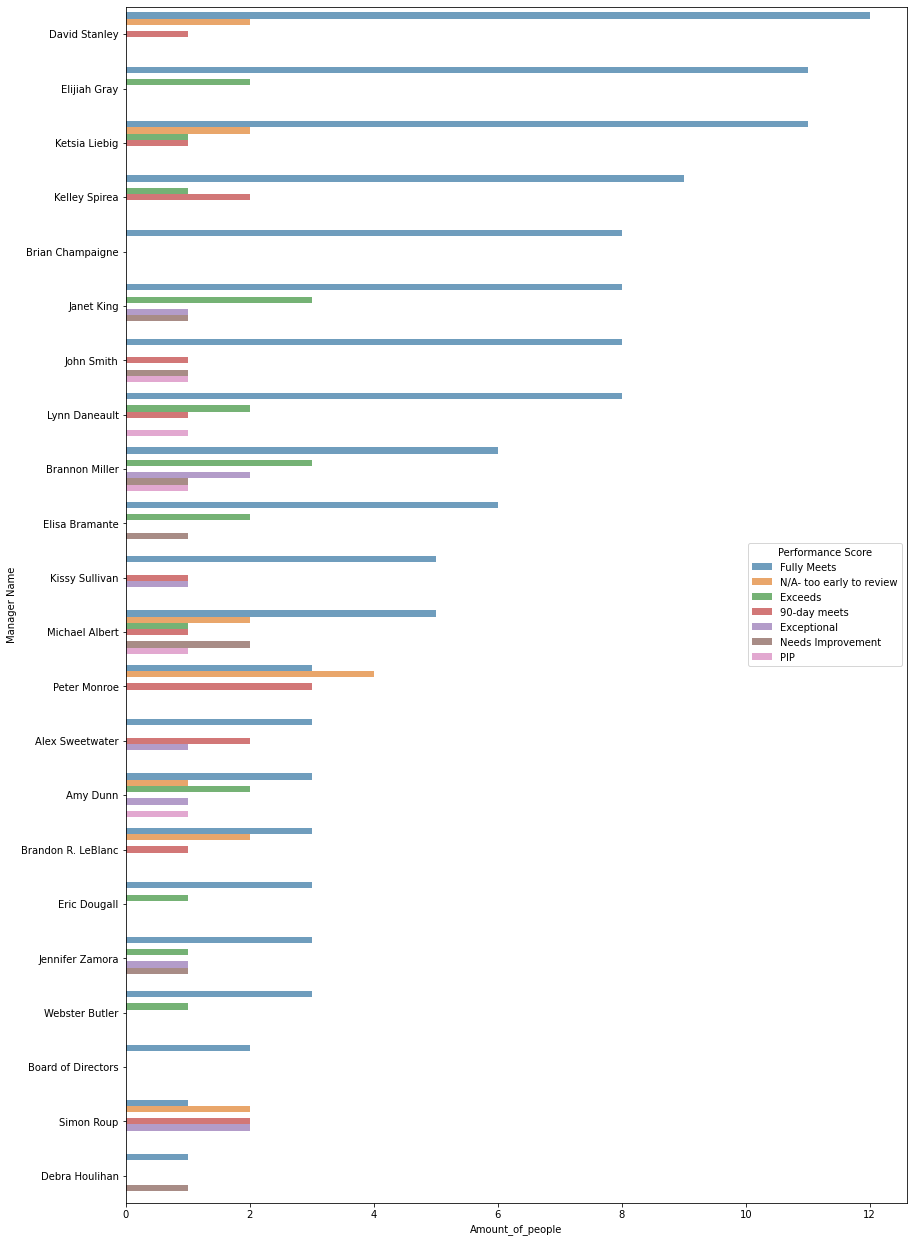

In [18]:
# Запрос на группировку по руководителю и оценке производительности.
# Так как мы имеем две таблицы, где есть непересекающиеся значения, то нужно их объединить в запросе

sql_str = """SELECT DISTINCT COUNT("Employee Name") AS "Amount_of_people", "Manager Name", "Performance Score"
        FROM 
        (SELECT "Employee Name", "Manager Name", "Performance Score" 
        FROM hr_dataset 
        WHERE "Employment Status" ='Active'
        UNION
        SELECT "Employee Name", "Manager Name", "Performance Score"
        FROM production_staff 
        WHERE "Employment Status" ='Active') AS foo
        GROUP BY "Manager Name", "Performance Score"
        ORDER BY "Amount_of_people" DESC;"""

cursor.execute(sql_str)
perf_score_depends = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

perf_score_depends = pd.DataFrame(perf_score_depends, columns=field_names)

# Наглядный вид распределения
plt.subplots(figsize=(14, 22))
sns.barplot(x='Amount_of_people', y='Manager Name', hue='Performance Score', data=perf_score_depends, alpha=0.7)

Оценим распределение людей по каждому руководителю, по каждой из представленных оценок и сравним с медианным значением в группе.

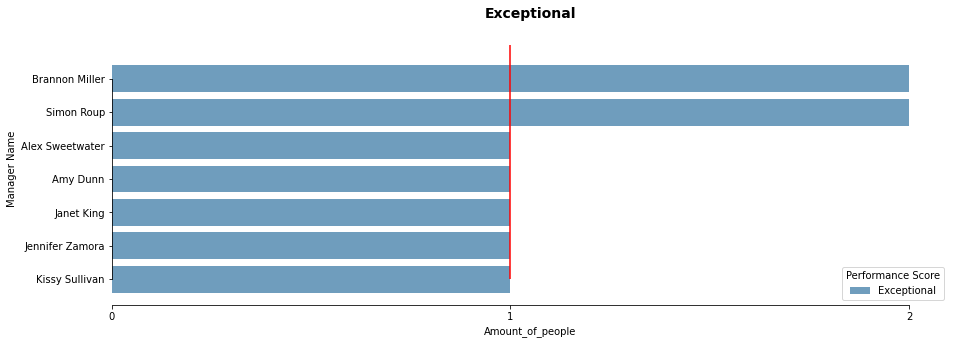

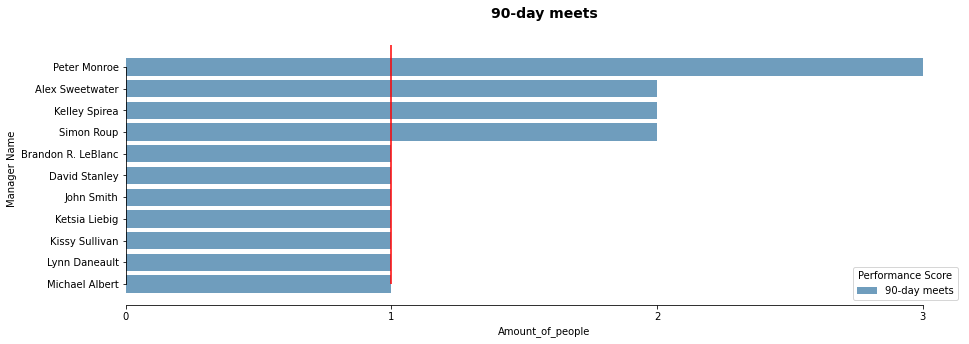

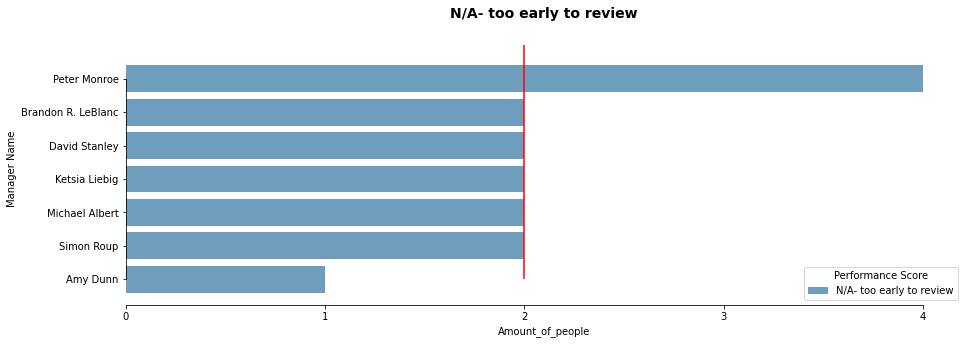

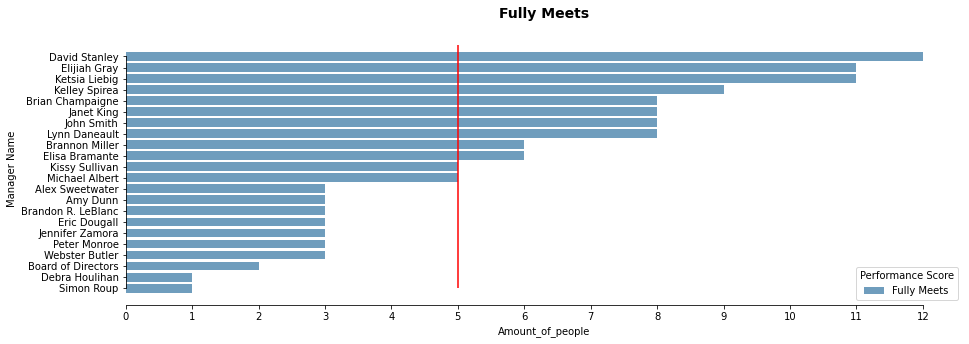

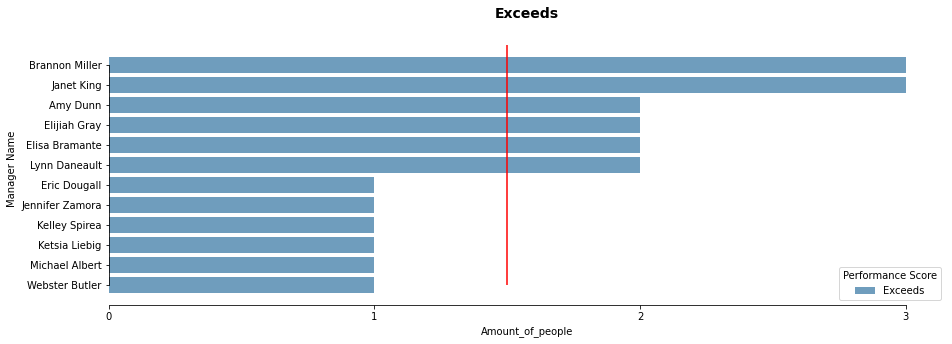

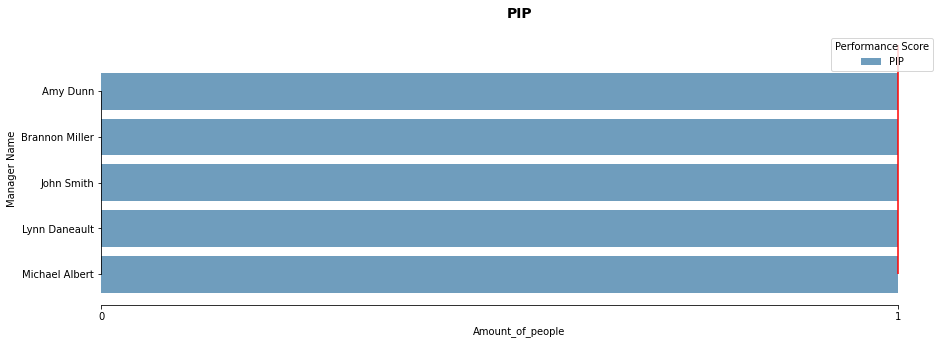

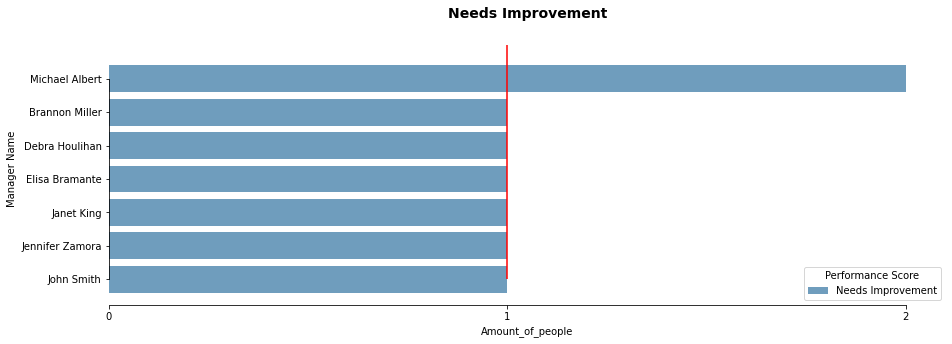

In [19]:
# Цикл на отрисовку каждой оценки производительности отдельно
for score in perf_score:

    # Запрос к БД    
    sql_str = f"""SELECT DISTINCT COUNT("Employee Name") AS "Amount_of_people", "Manager Name", "Performance Score"
        FROM 
        (SELECT "Employee Name", "Manager Name", "Performance Score" 
        FROM hr_dataset 
        WHERE "Performance Score" = '{score}' AND "Employment Status" ='Active'
        UNION
        SELECT "Employee Name", "Manager Name", "Performance Score"
        FROM production_staff 
        WHERE "Performance Score" = '{score}' AND "Employment Status" ='Active') AS foo
        GROUP BY "Manager Name", "Performance Score"
        ORDER BY "Amount_of_people" DESC;"""

    
    cursor.execute(sql_str)
    perf_score_depends = cursor.fetchall()

    num_fields = len(cursor.description)
    field_names = [i[0] for i in cursor.description]

    perf_score_depends = pd.DataFrame(perf_score_depends, columns=field_names)
    perf_score_depends.head()

    # Отрисовка графиков
    plt.subplots(figsize=(15, 5))
    sns.barplot(x='Amount_of_people', y='Manager Name', hue='Performance Score', data=perf_score_depends, alpha=0.7)
    
    plt.title(score, fontsize=14, pad=15, fontweight='bold')
    plt.vlines(perf_score_depends['Amount_of_people'].median(), -1, perf_score_depends['Manager Name'].count()-1, color = 'r')
    plt.xticks(np.arange(0, max(perf_score_depends['Amount_of_people']+1), 1))
    sns.despine(offset=0, trim=True)
    

Посмотрим есть ли среди сотрудников со статусом оценки производительности "N/A- too early to review" и сроком работы более 90 дней.

In [20]:
# Запрос на группировку по руководителю и оценке производительности
sql_str = f"""SELECT "Employee Name", "Manager Name", "Performance Score", "Days Employed"
        FROM hr_dataset 
        WHERE "Performance Score" = 'N/A- too early to review' AND "Days Employed" > 90 AND "Employment Status" ='Active'
        ORDER BY "Days Employed" DESC;"""

cursor.execute(sql_str)
not_review = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

not_review = pd.DataFrame(not_review, columns=field_names)
not_review.head(30)

,Employee Name,Manager Name,Performance Score,Days Employed
0,"Athwal, Sam",Ketsia Liebig,N/A- too early to review,1518
1,"Trang, Mei",David Stanley,N/A- too early to review,1378
2,"Rogers, Ivan",Simon Roup,N/A- too early to review,972
3,"Cisco, Anthony",Peter Monroe,N/A- too early to review,972
4,"Merlos, Carlos",Peter Monroe,N/A- too early to review,972
5,"Turpin, Jumil",Peter Monroe,N/A- too early to review,972
6,"Warfield, Sarah",Peter Monroe,N/A- too early to review,972
7,"Garcia, Raul",David Stanley,N/A- too early to review,972
8,"Gentry, Mildred",Michael Albert,N/A- too early to review,972
9,"Medeiros, Jennifer",Michael Albert,N/A- too early to review,972


In [21]:
conn.commit()

Можно сделать вывод о руководителях имеющих самы большой штат и самый маленький, а так же о том как они оценивают эффективность подчиненных.
Стоит обратить внимание на руководителя:
* Branon Miller, очень высоко ценит навыки своих сотрудников


Также стоит обратить внимание на большое количество сотрудников не проходивших квалификацию, у руководителей:
* Peter Monroe
* Amy Dunn
* Simon Roup
* Dsvid Stanley

Большое количество новых сотрудников в отделе у Peter Monroe.

Также были выявлены сотрудники, квалификацию которых стоит оценить ввиду большого срока работы.

## 3. Зависимость между продолжительностью работы в компании и семейным положением сотрудника.
***

Рассмотрим распределение женатых и не женатых сотрудников.

Text(0.5, 1.0, 'Распределение между женатыми и не женатыми сотрудниками')

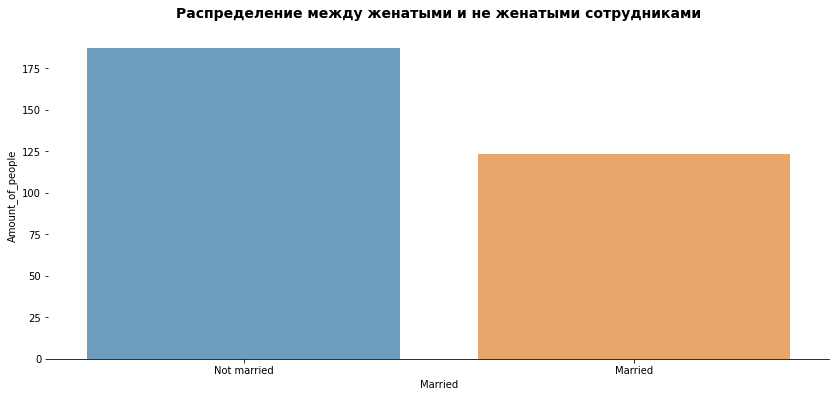

In [22]:
sql_str = """SELECT COUNT("Employee Number") AS "Amount_of_people", 
        CASE WHEN "marriedid" = 0 THEN 'Not married' ELSE 'Married' END AS "Married"
        FROM hr_dataset 
        GROUP BY "Married"
        ORDER BY "Amount_of_people" DESC;"""

cursor.execute(sql_str)
marriedid_depends = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

marriedid_depends = pd.DataFrame(marriedid_depends, columns=field_names)

plt.subplots(figsize=(14, 6))
sns.barplot(y='Amount_of_people', x="Married", data=marriedid_depends, alpha=0.7)
sns.despine(left=True)
plt.title('Распределение между женатыми и не женатыми сотрудниками', fontsize=14, pad=15, fontweight='bold')

Рассмотрим сотрудников состоящих в браке и не состоящих и оценим их время работы в компании,<br> 
чтобы оценить зависимость между этими факторами.

In [23]:
sql_str = """SELECT "Days Employed",
        CASE WHEN "marriedid" = 0 THEN 'Not married' ELSE 'Married' END AS "Married"
        FROM hr_dataset 
        ORDER BY "Married" DESC;"""

cursor.execute(sql_str)
marriedid_depends_exp = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

marriedid_depends_exp = pd.DataFrame(marriedid_depends_exp, columns=field_names)

Text(0.5, 1.0, 'Продолжительность работы между женатыми и не женатыми сотрудниками')

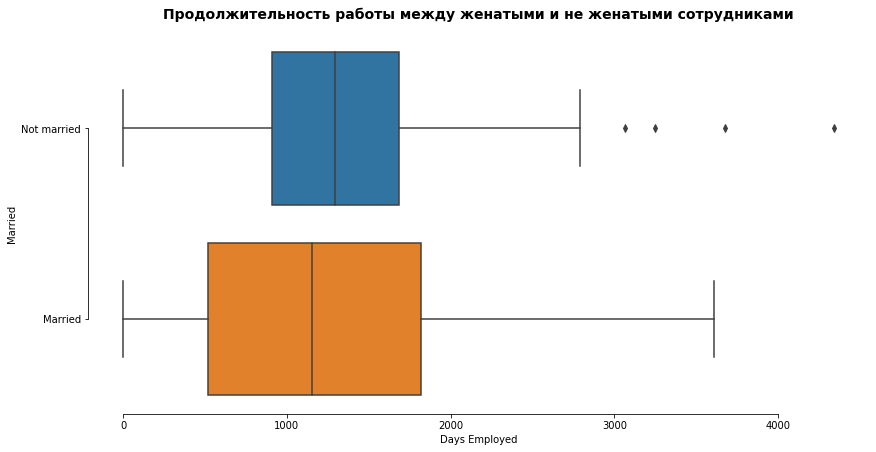

In [24]:
plt.subplots(figsize=(14, 7))
sns.boxplot(x='Days Employed', y="Married", data=marriedid_depends_exp)
sns.despine(offset=0, trim=True)
plt.title('Продолжительность работы между женатыми и не женатыми сотрудниками', fontsize=14, pad=15, fontweight='bold')

In [25]:
conn.commit()

Можно отметить, что несмотря на то что женатых сотрудников меньше, в среднем срок их работы больше, а медианное значение среди двух групп немного выше у не женатых.

## 4. Зависимость между продолжительностью работы в компании и возрастом сотрудника.
***

Для того, чтобы проследить зависимость между возрастом и продолжительностью работы, разобьем всех сотрудников на возрастные группы:
* До 30 лет
* От 30 до 40 лет
* От 40 до 50 лет
* От 50 до 60 лет
* Свыше 60 лет

Text(0.5, 1.0, 'Продолжительность работы взависимости от возраста')

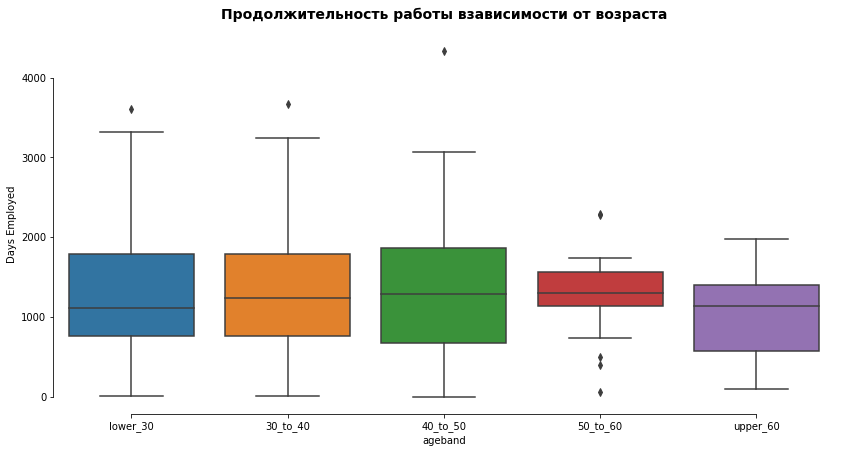

In [26]:
sql_str = """SELECT "age", "Days Employed",
    CASE
      WHEN hr_dataset.age <= 30 THEN 'lower_30'
      WHEN hr_dataset.age > 30 AND hr_dataset.age <= 40 THEN '30_to_40'
      WHEN hr_dataset.age > 40 AND hr_dataset.age <= 50 THEN '40_to_50'
      WHEN hr_dataset.age > 50 AND hr_dataset.age <= 60 THEN '50_to_60'
      WHEN hr_dataset.age > 60 THEN 'upper_60'
    END AS ageband
FROM hr_dataset
ORDER BY "age";"""

cursor.execute(sql_str)
age_depends = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

age_depends = pd.DataFrame(age_depends, columns=field_names)

plt.subplots(figsize=(14, 7))
sns.boxplot(y='Days Employed', x="ageband", data=age_depends)
sns.despine(offset=0, trim=True)
plt.title('Продолжительность работы взависимости от возраста', fontsize=14, pad=15, fontweight='bold')

## 5. Зависимость между полом сотрудника и отделом в компании.
***

Text(0.5, 1.0, 'Распределение по отделам взависимости от пола сотрудника')

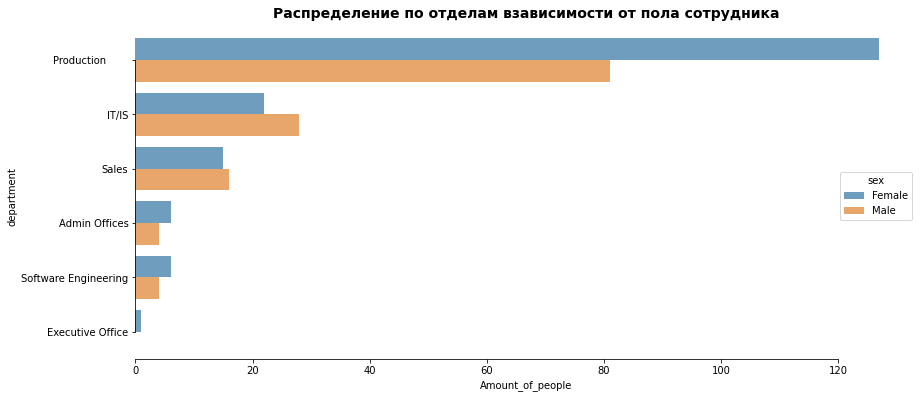

In [27]:
sql_str = """SELECT COUNT("Employee Number") AS "Amount_of_people", "sex", "department" 
        FROM hr_dataset 
        GROUP BY "department", "sex"
        ORDER BY "Amount_of_people" DESC;"""

cursor.execute(sql_str)
gender_depends = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

gender_depends = pd.DataFrame(gender_depends, columns=field_names)

plt.subplots(figsize=(14, 6))
sns.barplot(x='Amount_of_people', hue="sex", y="department", data=gender_depends, alpha=0.7)
sns.despine(offset=0, trim=True)
plt.title('Распределение по отделам взависимости от пола сотрудника', fontsize=14, pad=15, fontweight='bold')

Text(0.5, 1.0, 'Распределение по руководителям взависимости от пола сотрудника')

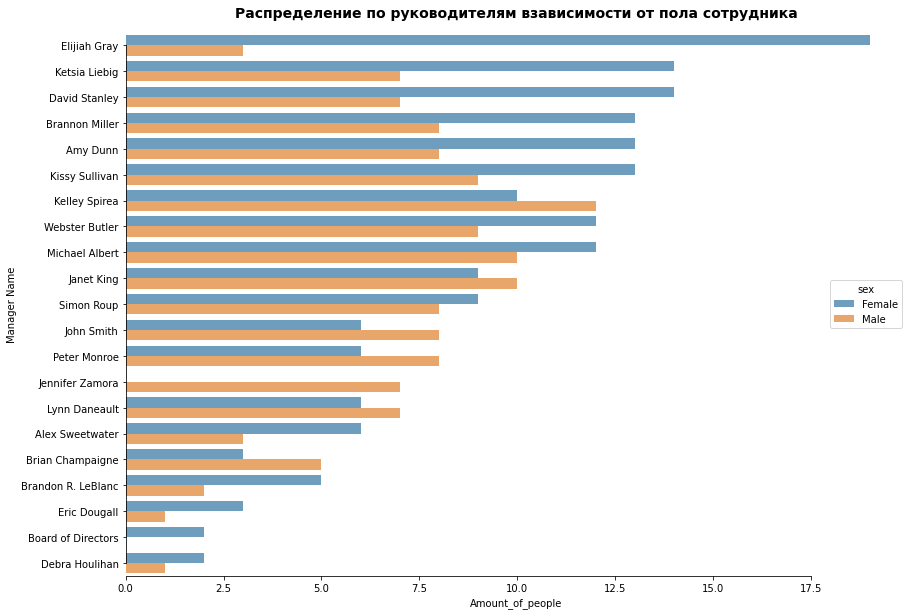

In [28]:
sql_str = """SELECT COUNT("Employee Number") AS "Amount_of_people", "sex", "Manager Name"
        FROM hr_dataset 
        GROUP BY "Manager Name", "sex"
        ORDER BY "Amount_of_people" DESC;"""

cursor.execute(sql_str)
gender_by_manager = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

gender_by_manager = pd.DataFrame(gender_by_manager, columns=field_names)

plt.subplots(figsize=(14, 10))
sns.barplot(x='Amount_of_people', hue="sex", y="Manager Name", data=gender_by_manager, alpha=0.7)
sns.despine(offset=0, trim=True)
plt.title('Распределение по руководителям взависимости от пола сотрудника', fontsize=14, pad=15, fontweight='bold')

In [29]:
conn.commit()

В целом мы видем достаточно ровное распределение без признаков гендерного неравенства.
В продакшн работает большинство женщин, а деление по другим отделам практически равное.
Среди руководителей отделов большинство женщин в отделах продакшн.
А в отделе Jennufer Zamora работаеют одни мужчины.

## 6. Эффективность затрат HR отдела.
***

Рассмотрим эффективность трат на привлечение сотрудников.<br>
Изузим распределение трат HR отдела за год и на основании имеющихся данных посмотрим на необходимость перераспределения трат.<br>
Выделем из базы всех сотрудников по каналам привлечения.<br>

Text(0.5, 1.0, 'Распределение трат на поиск сотрудников, %')

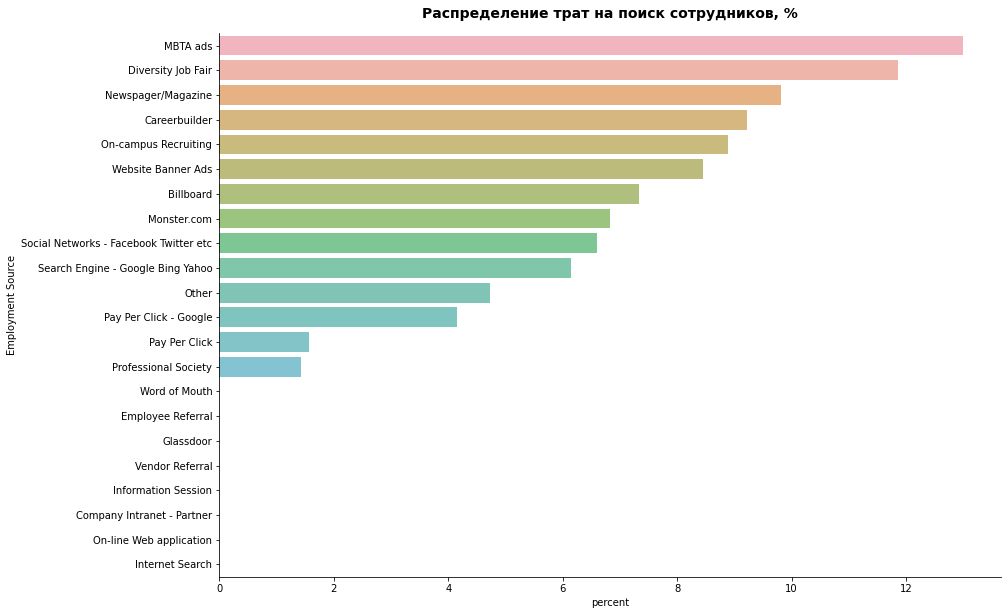

In [30]:
sql_str = """SELECT "Employment Source",
               sum("Total") as total_costs,
               sum("Total")*100 / sum(sum("Total")) over () as percent
             FROM recruiting_costs
             group by "Employment Source"
             ORDER by percent DESC;"""

cursor.execute(sql_str)
costs = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

costs = pd.DataFrame(costs, columns=field_names)

plt.subplots(figsize=(14, 10))
sns.barplot(x='percent', y="Employment Source", data=costs, alpha=0.7)
sns.despine(offset=0)
plt.title('Распределение трат на поиск сотрудников, %', fontsize=14, pad=15, fontweight='bold')

Text(0.5, 1.0, 'Распределение среди сотрудников по способу привлечения')

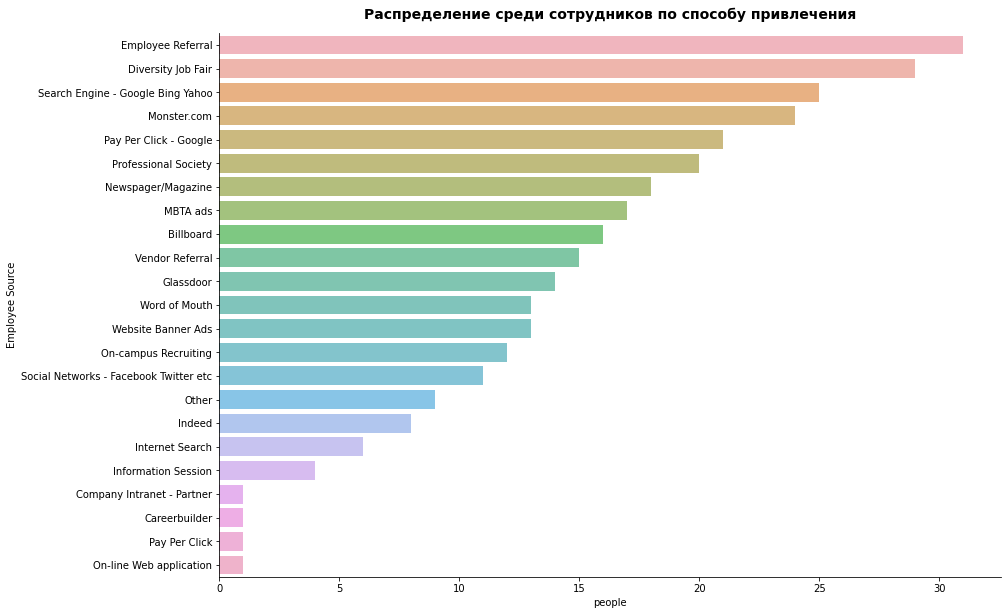

In [31]:
sql_str = """SELECT "Employee Source", COUNT("id") AS people
            FROM hr_dataset
            GROUP BY "Employee Source"
            ORDER by people DESC;"""

cursor.execute(sql_str)
recruts_sourse = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

recruts_sourse = pd.DataFrame(recruts_sourse, columns=field_names)

plt.subplots(figsize=(14, 10))
sns.barplot(x='people', y="Employee Source", data=recruts_sourse, alpha=0.7)
sns.despine(offset=0)
plt.title('Распределение среди сотрудников по способу привлечения', fontsize=14, pad=15, fontweight='bold')

Мы видим, что не всегда большие вложения, означают большую эффективность. Более подробно рассмотрим зависимость на scatterplot

Text(0.5, 1.0, 'Количество привлеченных сотрудников взависимости от затрат')

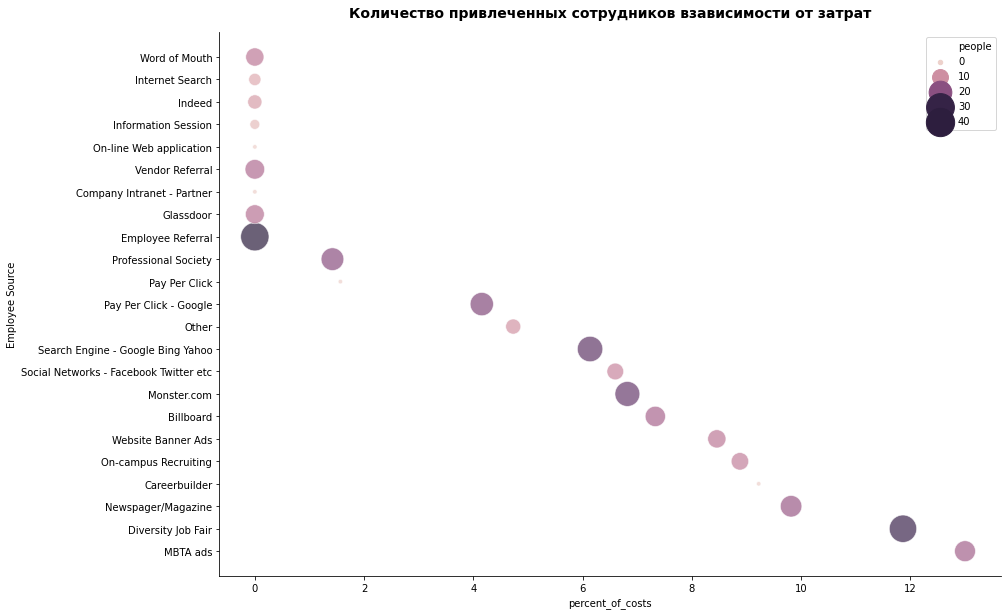

In [32]:
sql_str = """SELECT hr_dataset."Employee Source", COUNT(hr_dataset."id") AS people, 
             coalesce(AVG(recruiting_costs."Total"), 0) as total_costs,
             coalesce(AVG(recruiting_costs."Total")*100 / sum(AVG(recruiting_costs."Total")) over (), 0) as percent_of_costs
             FROM hr_dataset
                 LEFT JOIN recruiting_costs ON recruiting_costs."Employment Source"=hr_dataset."Employee Source"
             GROUP BY "Employee Source"
             ORDER by percent_of_costs DESC;"""

cursor.execute(sql_str)
recruts_sourse_cost = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

recruts_sourse_cost = pd.DataFrame(recruts_sourse_cost, columns=field_names)

plt.subplots(figsize=(14, 10))
sns.scatterplot(y='Employee Source', x="percent_of_costs", hue="people", data=recruts_sourse_cost, 
                alpha=0.7, 
                size="people", 
                sizes=(20, 800))
sns.despine(offset=0)
plt.title('Количество привлеченных сотрудников взависимости от затрат', fontsize=14, pad=15, fontweight='bold')

In [33]:
conn.commit()

Как можно заметить большая часть сотрудников в компании находят работу, через пути не требующие затрат.
Можно сократить расходы по поиску сотрудников через "MBTA ads", "Newspaper" и "Diversity Job Fair" и перераспределить их по более дешевым категориям поиска.

## 7. Зависимость между Performance Score и жалобами/ошибками сотрудника.
***

In [34]:
sql_str = """SELECT "Performance Score", ROUND(AVG("Daily Error Rate"), 2) AS AVG_Daily_error, COUNT("Employee Name") AS State, 
             ROUND(AVG("90-day Complaints"), 2) AS AVG_complaints_for_90_days
             FROM production_staff
             WHERE "Performance Score" IS NOT NULL AND "Employment Status" = 'Active'
             GROUP BY "Performance Score"
             ORDER by AVG_Daily_error DESC;"""

cursor.execute(sql_str)
error_rate = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

error_rate = pd.DataFrame(error_rate, columns=field_names)

Text(0.5, 1.0, 'Среднее количество ошибок сотрудника в день')

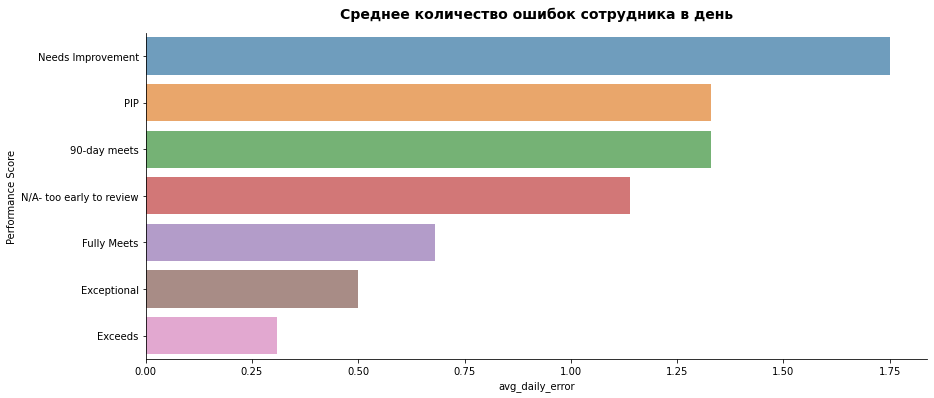

In [35]:
plt.subplots(figsize=(14, 6))
sns.barplot(x='avg_daily_error', y="Performance Score", data=error_rate, alpha=0.7)
sns.despine(offset=0)
plt.title('Среднее количество ошибок сотрудника в день', fontsize=14, pad=15, fontweight='bold')

Text(0.5, 1.0, 'Среднее количество жалоб за 90 дней')

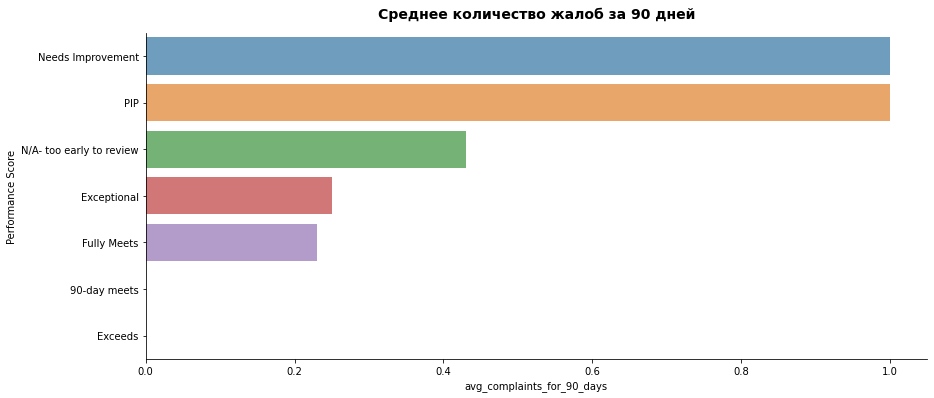

In [36]:
error_rate = error_rate.sort_values(by=['avg_complaints_for_90_days'], ascending=False)
plt.subplots(figsize=(14, 6))
sns.barplot(x='avg_complaints_for_90_days', y="Performance Score", data=error_rate, alpha=0.7)
sns.despine(offset=0)
plt.title('Среднее количество жалоб за 90 дней', fontsize=14, pad=15, fontweight='bold')

In [37]:
conn.commit()

Количество жалоб на сотрудников и среднее количество ежидневных ошибок напрямую коррелирует с "Perfomance Score".
Т.е. чем выше навыки сотрудника, тем меньше ошибок он допускает. Соответстенно методика оценки персонала верная.

## 8. Зависимость оплаты от департамента.
***

In [38]:
sql_str = """SELECT "Pay Rate", "Performance Score", "department", "Manager Name"
             
             FROM hr_dataset
             WHERE "Employment Status" ='Active'
             ORDER by "Pay Rate" DESC;"""

cursor.execute(sql_str)
pay_rate = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

pay_rate = pd.DataFrame(pay_rate, columns=field_names)

Text(0.5, 1.0, 'Зависимость оплаты от департамента')

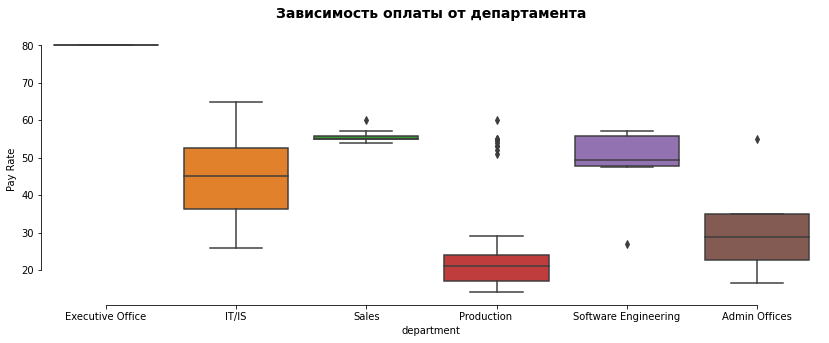

In [39]:
plt.subplots(figsize=(14, 5))
sns.boxplot(y='Pay Rate', x="department", data=pay_rate)
sns.despine(offset=0, trim=True)
plt.title('Зависимость оплаты от департамента', fontsize=14, pad=15, fontweight='bold')

Можно отметить самые высокие зарплаты среди руководителей
Затем следуют отделы продаж, инжиревов, IT
Самые низкие зарплаты среди работников продакшн.

## 9. Зависимость оплаты от Perfomance score.
***

In [40]:
sql_str = """SELECT AVG("Pay Rate") AS AVG_Pay, "Performance Score", "department"
             
             FROM hr_dataset
             WHERE "Employment Status" ='Active'
             GROUP BY "department", "Performance Score"
             ORDER by AVG_Pay DESC;"""

cursor.execute(sql_str)
pay_rate_pc = cursor.fetchall()

num_fields = len(cursor.description)
field_names = [i[0] for i in cursor.description]

pay_rate_pc = pd.DataFrame(pay_rate_pc, columns=field_names)

Text(0.5, 1.0, 'Зависимость средней оплаты от perfomance score')

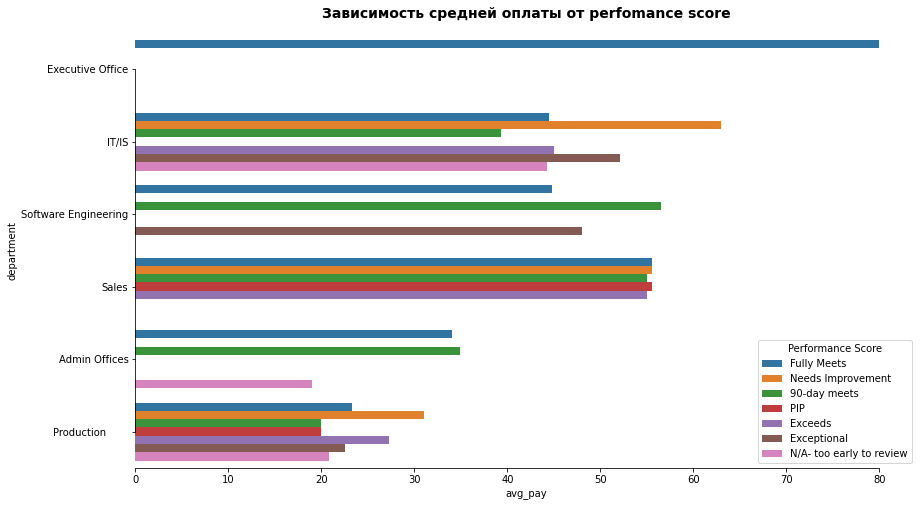

In [41]:
plt.subplots(figsize=(14, 8))
sns.barplot(x='avg_pay', y="department", hue="Performance Score", data=pay_rate_pc)
sns.despine(offset=0, trim=True)
plt.title('Зависимость средней оплаты от perfomance score', fontsize=14, pad=15, fontweight='bold')

Из диаграммы следует что средняя зарплата у людей с оценкой "Нуждаются в улучшении" в отделах IT и Продакшн выше, чем средняя зарплата у сотрудников, обладающих "Исключительными навыками".
В отделе продаж распределение очень ровное среди всех групп.

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

## Выгрузка постов
***

In [42]:
from pandas.io.json import json_normalize
import pandas as pd
from datetime import datetime, timedelta
import json
import re
from googletrans import Translator

import requests

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

***
Выгрузка закоменчена, все посты по этой выгрузке записаны в файл, дальше работа велась по нему, чтобы каждый раз не обновлять токен.
***

In [43]:
#vk_token = '???????????????????????????'


#url = 'https://api.vk.com/method/account.getProfileInfo?access_token=' + str(vk_token) + '&v=5.92'
#response = getjson(url)

In [44]:
# получаем последнюю запись из паблика Skillbox Вконтакте
#url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=1&v=5.92'
#response = getjson(url)

In [45]:
# Сохраняем последнюю запись 
#df_1 = pd.DataFrame.from_dict(json_normalize(response['response']['items']))

In [46]:
# Цикл на выгрузку постов
#i = 1

#for a in range(20):
    # сдвигаем запрос и получаем предпоследнюю запись из паблика Skillbox Вконтакте
#    url = f'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=' + str(i) + '&count=100&v=5.92'
#    response = getjson(url)
#    df_temp = pd.DataFrame.from_dict(json_normalize(response['response']['items']))
#    df_1 = pd.concat([df_1, df_temp], axis=0, sort=False)
#    i += 100

In [47]:
# Преобразуем дату
#df_1['Time'] = df_1['date'].apply(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S'))
#df_1.reset_index(inplace=True)

In [48]:
# Сохраняем копию постов
#df_1.to_json('vk_posts.json')

***

In [49]:
df = pd.read_json('vk_posts.json')

In [50]:
df.head()

,index,id,from_id,owner_id,date,marked_as_ads,post_type,text,attachments,is_favorite,...,likes.count,likes.user_likes,likes.can_like,likes.can_publish,reposts.count,reposts.user_reposted,views.count,post_source.platform,copy_history,Time
0,0,108583,-66669811,-66669811,2020-10-10 08:29:08,0,post,Эта неделя богата на дни рождения наших любимы...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,...,50,0,1,1,2,0,5121,None,None,2020-10-10 11:29:08
1,0,106815,-66669811,-66669811,2020-10-09 15:00:22,0,post,"Кем работать, если уже перепробовал почти всё?...","[{'type': 'link', 'link': {'url': 'https://ski...",False,...,24,0,1,1,1,0,8526,None,None,2020-10-09 18:00:22
2,1,106747,-66669811,-66669811,2020-10-09 10:39:13,0,post,Как стать хорошим дизайнером?\n\nПрокачивать с...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,...,33,0,1,1,3,0,10014,None,None,2020-10-09 13:39:13
3,2,105018,-66669811,-66669811,2020-10-08 15:40:53,0,post,Наши друзья из AIC запускают партнерскую прогр...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,...,21,0,1,1,1,0,12575,None,None,2020-10-08 18:40:53
4,3,104966,-66669811,-66669811,2020-10-08 13:23:04,0,post,Мечтаете связать свою жизнь с футболом?\nSkill...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,...,23,0,1,1,2,0,13684,None,None,2020-10-08 16:23:04


df.info()

In [51]:
df['Time'].min()

'2018-08-17 10:30:01'

In [52]:
df['Time'].max()

'2020-10-10 11:29:08'

Для анализа оставим данные с начала 2019 года и по текущий момент. Текущий месяц исключим, так как он не полный.
* Просмотрим динамику публикаций за выбранный период.
* Динамику вовлеченности.
* Влияние пандемии на активность.

In [53]:
# Преобразование к дате
df['Time'] = pd.to_datetime(df['Time'])

# Выделим год, месяц, день недели и час публикации
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df['day_of_week'] = df['Time'].dt.weekday
df['hour'] = df['Time'].dt.hour

In [54]:
# Преобразование в разрезе год-месяц
df['Y_M'] = df['date'].dt.strftime('%Y-%b')

In [55]:
# Удаляем ненужные данные, не подходящие в выбранный промежуток времени
df = df[(df['year'] >= 2019) & (df['Y_M'] != df['Time'].max().strftime('%Y-%b'))]

In [56]:
df.head()

,index,id,from_id,owner_id,date,marked_as_ads,post_type,text,attachments,is_favorite,...,reposts.user_reposted,views.count,post_source.platform,copy_history,Time,year,month,day_of_week,hour,Y_M
18,17,100940,-66669811,-66669811,2020-09-30 15:00:09,0,post,Комментировать свой код — обязательный навык п...,"[{'type': 'link', 'link': {'url': 'https://ski...",False,...,0,16371,None,None,2020-09-30 18:00:09,2020,9,2,18,2020-Sep
19,18,100911,-66669811,-66669811,2020-09-30 08:15:31,0,post,Почему отделам маркетинга и продаж не всегда п...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",False,...,0,16815,None,None,2020-09-30 11:15:31,2020,9,2,11,2020-Sep
20,19,100808,-66669811,-66669811,2020-09-29 16:16:52,0,post,"Цитата, достойная записи: «Если дизайнер делае...","[{'type': 'link', 'link': {'url': 'https://ski...",False,...,0,18214,None,None,2020-09-29 19:16:52,2020,9,1,19,2020-Sep
21,20,100779,-66669811,-66669811,2020-09-29 09:47:17,0,post,Самоизоляция 2020 года стала культурным феноме...,"[{'type': 'video', 'video': {'access_key': '4d...",False,...,0,18525,None,None,2020-09-29 12:47:17,2020,9,1,12,2020-Sep
22,21,100672,-66669811,-66669811,2020-09-28 16:14:04,0,post,Странное словечко. А это точно не ругательство...,"[{'type': 'link', 'link': {'url': 'https://ski...",False,...,0,18531,None,None,2020-09-28 19:14:04,2020,9,0,19,2020-Sep


Рассмотрим, какие признаки могут пригодится при анализе, ненужные откинем.

In [57]:
df = df.drop(['id', 'from_id', 'owner_id'], axis=1)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 18 to 1487
Data columns (total 26 columns):
index                       1470 non-null int64
date                        1470 non-null datetime64[ns]
marked_as_ads               1470 non-null int64
post_type                   1470 non-null object
text                        1470 non-null object
attachments                 1464 non-null object
is_favorite                 1470 non-null bool
post_source.type            1470 non-null object
comments.count              1470 non-null int64
comments.can_post           1470 non-null int64
comments.groups_can_post    1470 non-null bool
likes.count                 1470 non-null int64
likes.user_likes            1470 non-null int64
likes.can_like              1470 non-null int64
likes.can_publish           1470 non-null int64
reposts.count               1470 non-null int64
reposts.user_reposted       1470 non-null int64
views.count                 1470 non-null int64
post_source.platf

In [59]:
df['post_type'].unique()

array(['post'], dtype=object)

In [60]:
df['marked_as_ads'].unique()

array([0], dtype=int64)

In [61]:
df['is_favorite'].unique()

array([False])

In [62]:
df['post_source.type'].unique()

array(['api', 'vk'], dtype=object)

In [63]:
df['comments.can_post'].unique()

array([1], dtype=int64)

In [64]:
df['comments.groups_can_post'].unique()

array([ True])

In [65]:
df['likes.can_like'].unique()

array([1], dtype=int64)

In [66]:
df['likes.can_publish'].unique()

array([1], dtype=int64)

In [67]:
df = df.drop(['post_type', 'marked_as_ads', 'is_favorite', 'comments.can_post', 
              'comments.groups_can_post', 'likes.can_like', 'likes.can_publish',
              'post_source.platform', 'copy_history', 'reposts.user_reposted', 'likes.user_likes', 'index'], axis=1)

In [68]:
df.head(5)

,date,text,attachments,post_source.type,comments.count,likes.count,reposts.count,views.count,Time,year,month,day_of_week,hour,Y_M
18,2020-09-30 15:00:09,Комментировать свой код — обязательный навык п...,"[{'type': 'link', 'link': {'url': 'https://ski...",api,4,22,3,16371,2020-09-30 18:00:09,2020,9,2,18,2020-Sep
19,2020-09-30 08:15:31,Почему отделам маркетинга и продаж не всегда п...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",api,2,49,8,16815,2020-09-30 11:15:31,2020,9,2,11,2020-Sep
20,2020-09-29 16:16:52,"Цитата, достойная записи: «Если дизайнер делае...","[{'type': 'link', 'link': {'url': 'https://ski...",api,13,51,1,18214,2020-09-29 19:16:52,2020,9,1,19,2020-Sep
21,2020-09-29 09:47:17,Самоизоляция 2020 года стала культурным феноме...,"[{'type': 'video', 'video': {'access_key': '4d...",api,3,37,2,18525,2020-09-29 12:47:17,2020,9,1,12,2020-Sep
22,2020-09-28 16:14:04,Странное словечко. А это точно не ругательство...,"[{'type': 'link', 'link': {'url': 'https://ski...",api,0,66,12,18531,2020-09-28 19:14:04,2020,9,0,19,2020-Sep


### 2. Динамика просмотров.
***

Рассмотрим, как изменялось со временем количество просмотров постов.

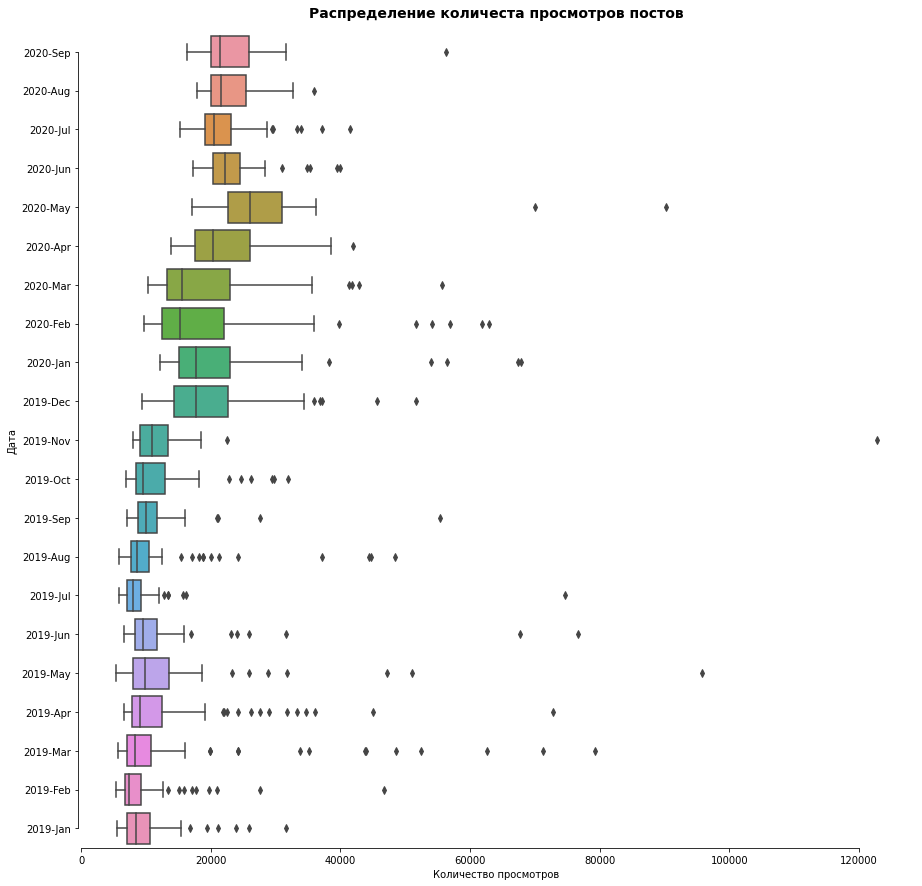

In [69]:
plt.subplots(figsize=(15, 15))
plt.title('Распределение количеста просмотров постов', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='views.count', y='Y_M', data=df)
plt.xlabel('Количество просмотров', fontsize=10)
plt.ylabel('Дата', fontsize=10)
sns.despine(offset=0, trim=True)

Можно отметить рост аудитории, т.к. растет количество просмотров. Пик количества просмотров пришелся на май 2020 года, во время пандемии. Рост в пиковый месяц возможно связан или с ростом свободного времени населения или с увелечение промо-активностей.
После пика, количество просмотров уменьшилось, но сохранился положительный тренд на рост.

### 3. Динамика количества публикаций.
***

Рассмотрим как изменялось количество публикаций.

In [70]:
df_grouped_posts = df.groupby(['Y_M', 'year', 'month']).agg({'text' : 'count'}).reset_index()\
    .sort_values(by=['year', 'month'])

order = df_grouped_posts.sort_values(by=['year', 'month'], ascending=True)['Y_M'].to_list()

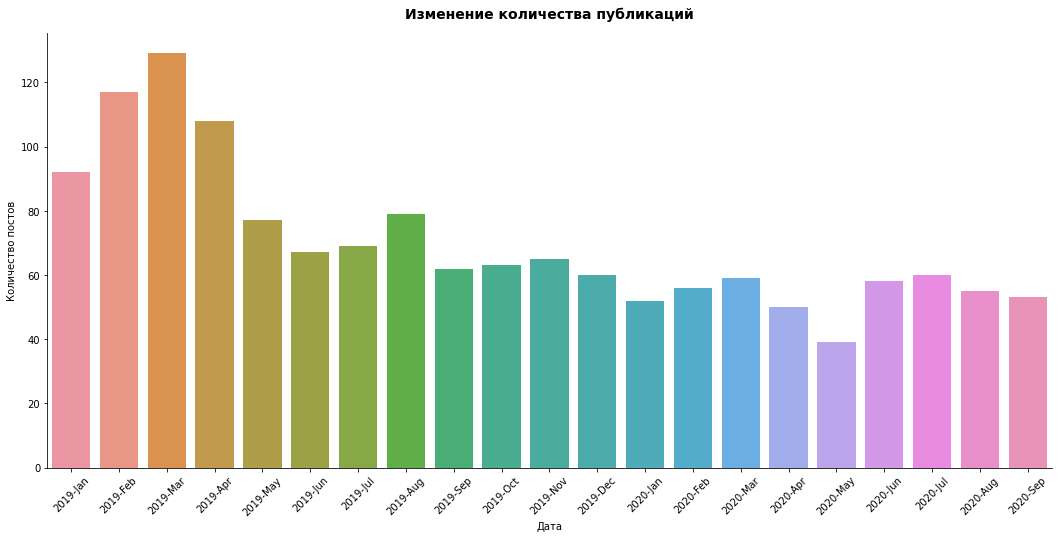

In [71]:
plt.subplots(figsize=(18, 8))

plt.title('Изменение количества публикаций', fontsize=14, pad=15, fontweight='bold')
gr = sns.barplot(x='Y_M', y='text', data=df_grouped_posts)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylabel('Количество постов', fontsize=10)
plt.xlabel('Дата', fontsize=10)
gr.set_xticklabels(gr.get_xticklabels(), rotation=45)
plt.show()

Можно отметить, что количество публикаций снижается, а количество просмотров увеличивается. Значит происходят изменения в наполнении контента. Он становится более качественным. То есть более ориентировнным на публику, и как следствие переходит в рост вовлеченности.<br>
В мае, когда было максимальное количество просмотров, наблюдается наименьшее количество публикаций.

### 4. Динамика активностей.
***

Посмотрим как изменялось со временем количество активностей. Под активностями принимаем суммарно лайки, комментарии, репосты.

In [72]:
df['activity'] = df['comments.count'] + df['likes.count'] + df['reposts.count']

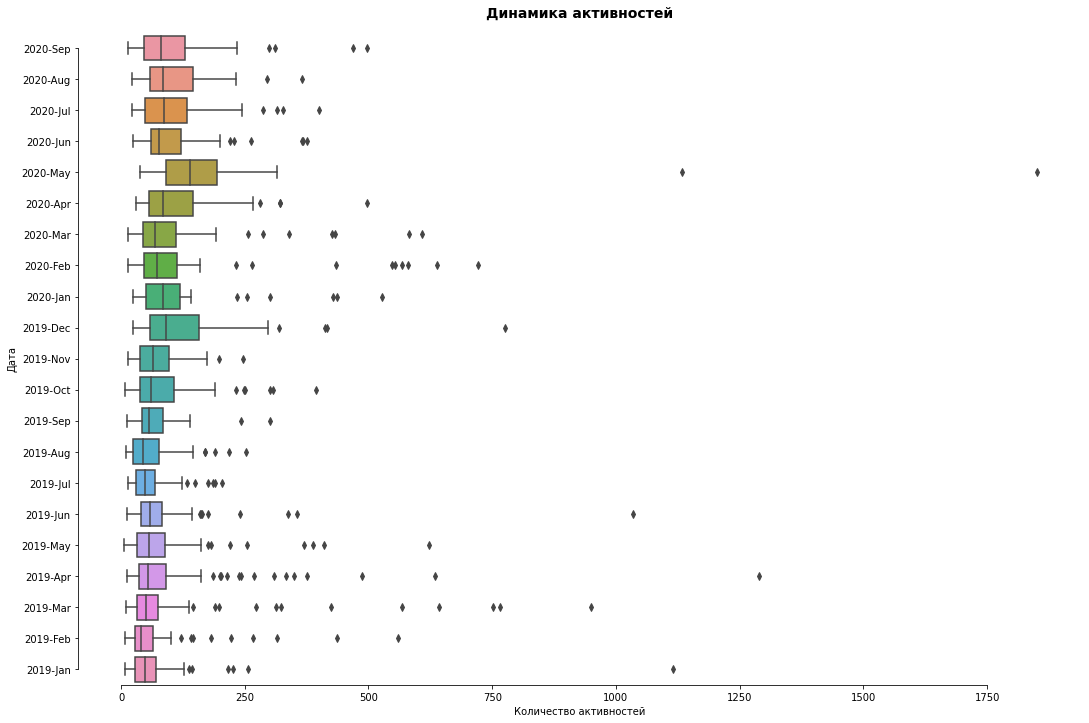

In [73]:
plt.subplots(figsize=(18, 12))
plt.title('Динамика активностей', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='activity', y='Y_M', data=df)
plt.xlabel('Количество активностей', fontsize=10)
plt.ylabel('Дата', fontsize=10)
sns.despine(offset=0, trim=True)

Посмотрим на изменение конверсий. Отношение активностей к просмотрам поста.

In [74]:
df['conversy'] = (df['activity'] / df['views.count']) * 100

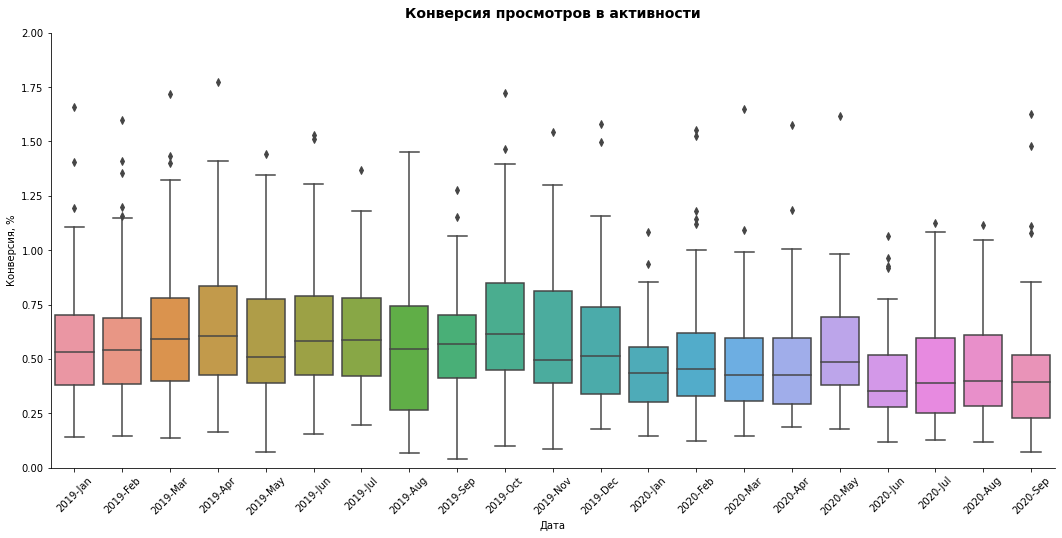

In [75]:
plt.subplots(figsize=(18, 8))

plt.title('Конверсия просмотров в активности', fontsize=14, pad=15, fontweight='bold')
gr = sns.boxplot(x='Y_M', y='conversy', data=df, order=order)
plt.ylim([0,2])
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylabel('Конверсия, %', fontsize=10)
plt.xlabel('Дата', fontsize=10)
gr.set_xticklabels(gr.get_xticklabels(), rotation=45)
plt.show()

Можно отметить рост активностей с течением времени, но в то же время падение конверсии.
То есть аудитория растет, но снижается активность участников сообщества.

### 5. Распределение просмотров и активностей по дням недели.
***

In [76]:
df['day_of_week_lit'] = df['Time'].dt.weekday_name

In [77]:
day_order = df[['day_of_week', 'day_of_week_lit']].sort_values(by=['day_of_week'])['day_of_week_lit'].unique()

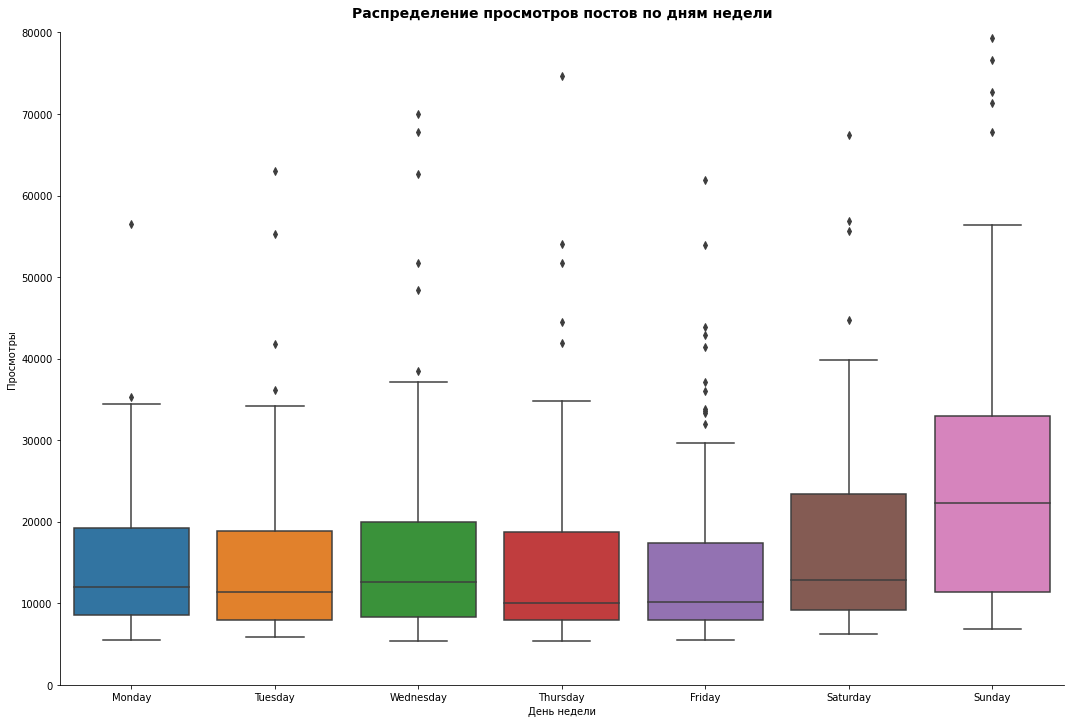

In [78]:
plt.subplots(figsize=(18, 12))

plt.title('Распределение просмотров постов по дням недели', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='day_of_week_lit', y='views.count', data=df, order=day_order)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylim([0, 80000])
plt.ylabel('Просмотры', fontsize=10)
plt.xlabel('День недели', fontsize=10)
plt.show()

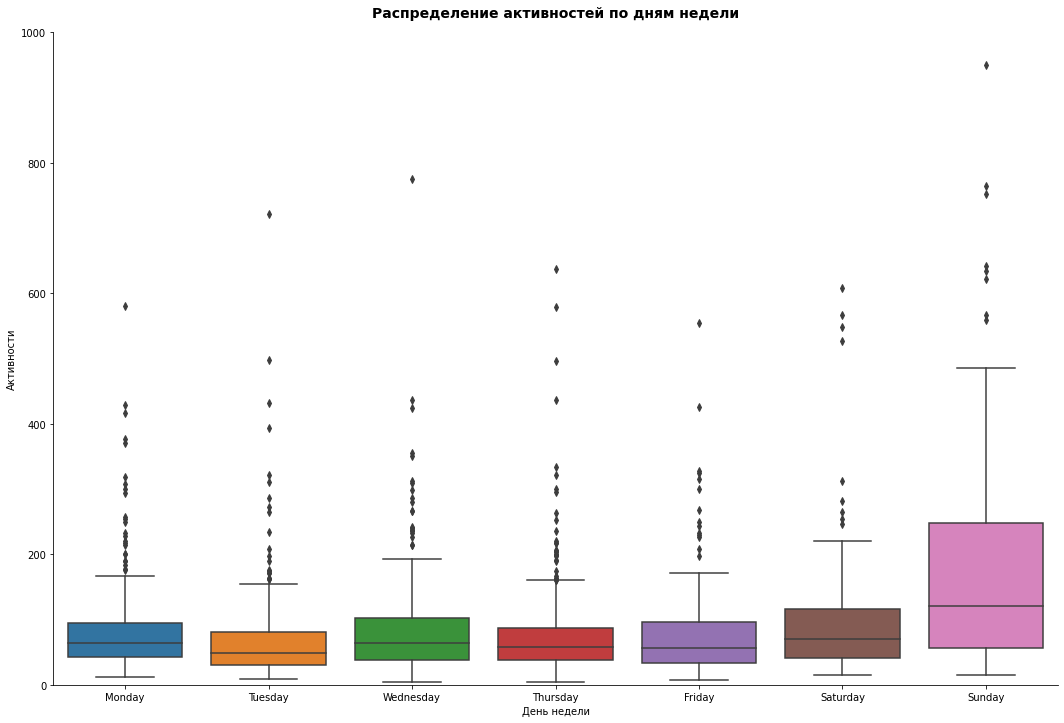

In [79]:
plt.subplots(figsize=(18, 12))

plt.title('Распределение активностей по дням недели', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='day_of_week_lit', y='activity', data=df, order=day_order)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylim([0, 1000])
plt.ylabel('Активности', fontsize=10)
plt.xlabel('День недели', fontsize=10)
plt.show()

Количество просмотров, лайков, репостов и комментариев сильно растет у постов опубликованных в воскресенье.

### 6. Распределение публикаций по дням недели.
***

Рассмотрим как изменилось количество публикаций по дням недели за 2019 год и за 2020.

In [80]:
df_grouped_day = df[df['year'] == 2019]
df_grouped_day = df.groupby(['day_of_week_lit']).agg({'text' : 'count'}).reset_index()

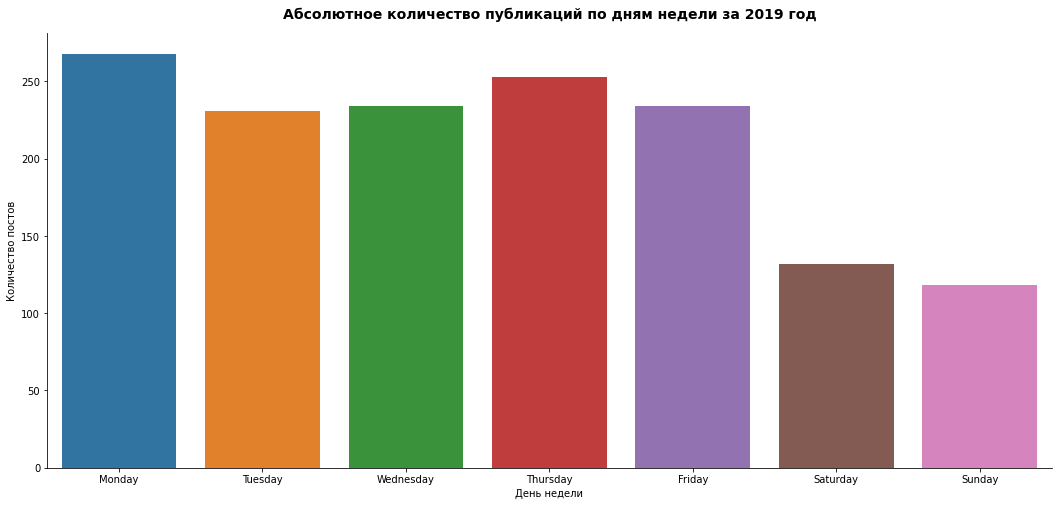

In [81]:
plt.subplots(figsize=(18, 8))

plt.title('Абсолютное количество публикаций по дням недели за 2019 год', fontsize=14, pad=15, fontweight='bold')
sns.barplot(x='day_of_week_lit', y='text', data=df_grouped_day, order=day_order)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylabel('Количество постов', fontsize=10)
plt.xlabel('День недели', fontsize=10)
plt.show()

In [82]:
df_grouped_day_2020 = df[df['year'] == 2020]
df_grouped_day_2020 = df_grouped_day_2020.groupby(['day_of_week_lit']).agg({'text' : 'count'}).reset_index()

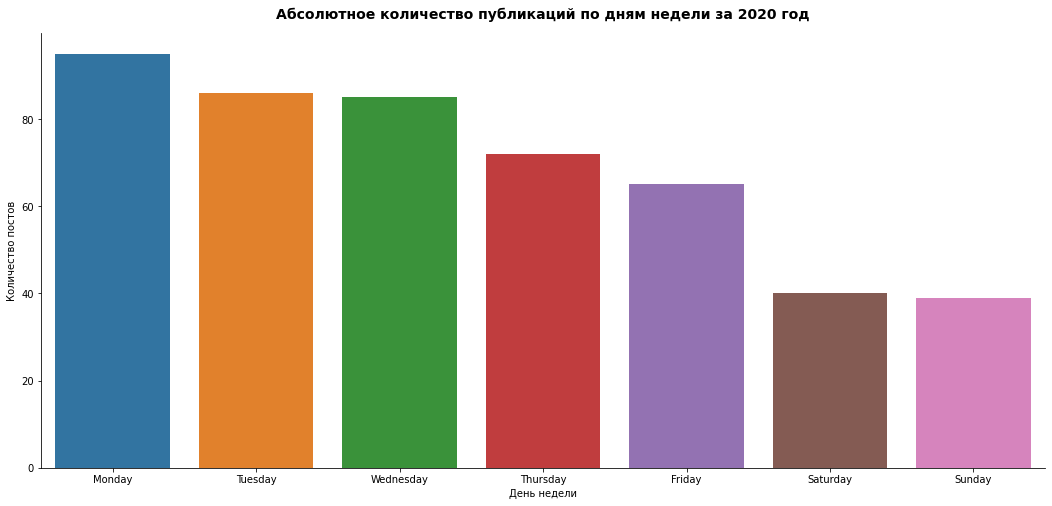

In [83]:
plt.subplots(figsize=(18, 8))

plt.title('Абсолютное количество публикаций по дням недели за 2020 год', fontsize=14, pad=15, fontweight='bold')
sns.barplot(x='day_of_week_lit', y='text', data=df_grouped_day_2020, order=day_order)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylabel('Количество постов', fontsize=10)
plt.xlabel('День недели', fontsize=10)
plt.show()

Как мы видим пропорции в публикациях изменились не сильно. 
В целом, количество публикаций снижается к выходным, хотя по выходным наблюдается рост активности сообщества.

### 7. Распределение просмотров и активностей по часам.
***

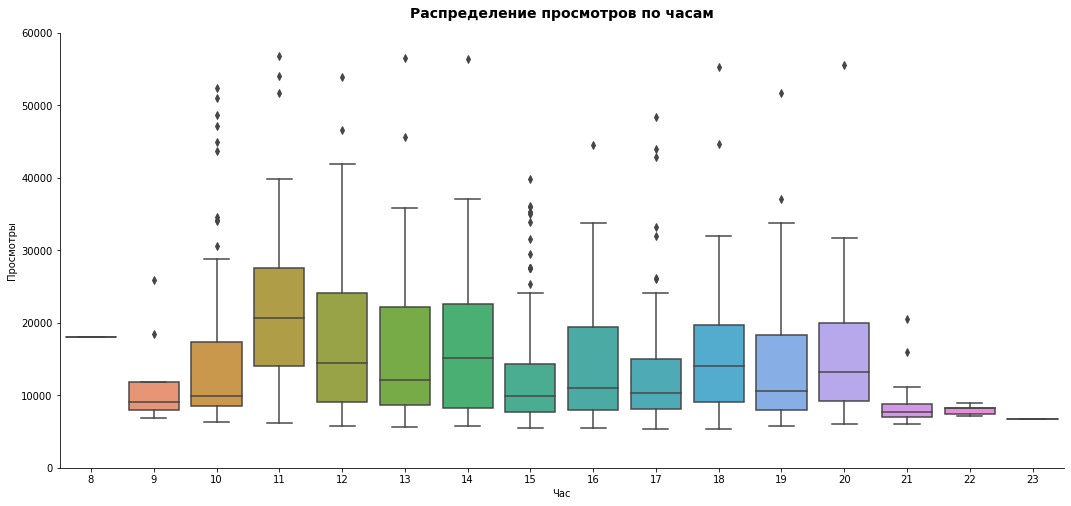

In [84]:
plt.subplots(figsize=(18, 8))

plt.title('Распределение просмотров по часам', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='hour', y='views.count', data=df)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylim([0, 60000])
plt.ylabel('Просмотры', fontsize=10)
plt.xlabel('Час', fontsize=10)
plt.show()

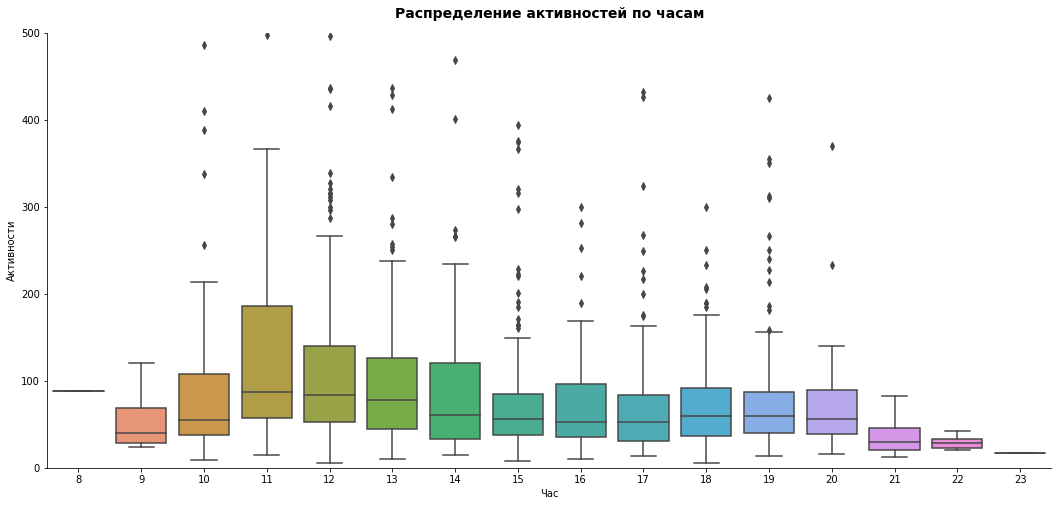

In [85]:
plt.subplots(figsize=(18, 8))

plt.title('Распределение активностей по часам', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='hour', y='activity', data=df)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylim([0, 500])
plt.ylabel('Активности', fontsize=10)
plt.xlabel('Час', fontsize=10)
plt.show()

Прослеживается прямая корреляция между просмотрами и активностями.
Проверим, есть ли внутреннее распределение по просмотрам взависимости от дня недели.

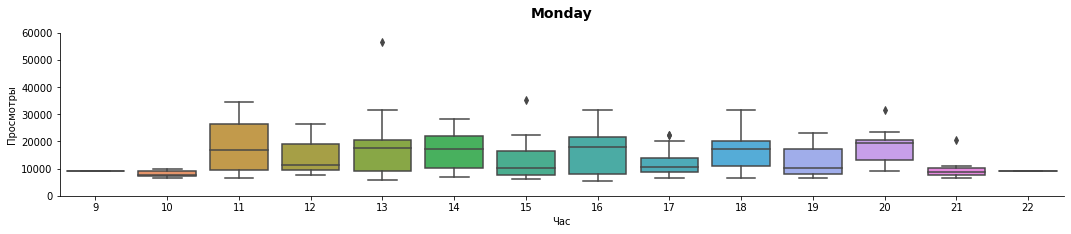

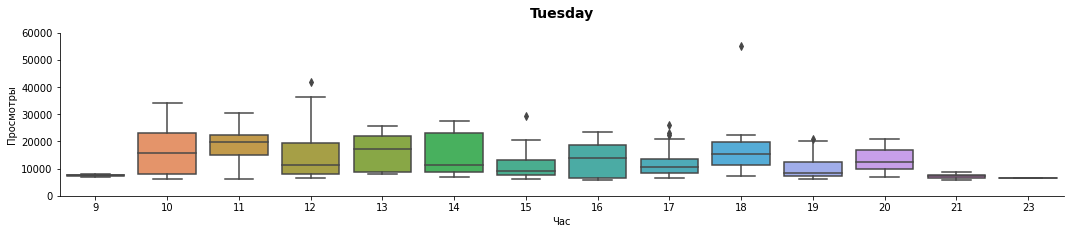

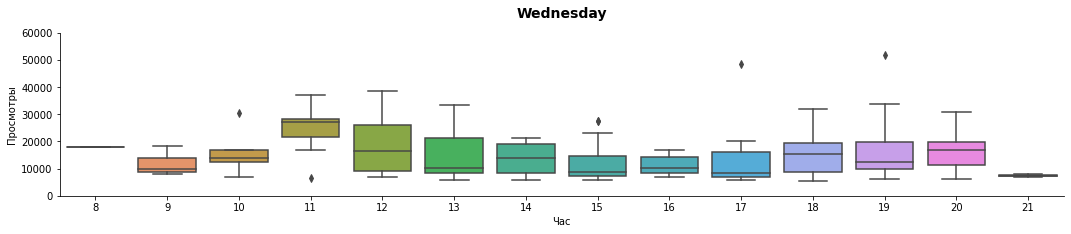

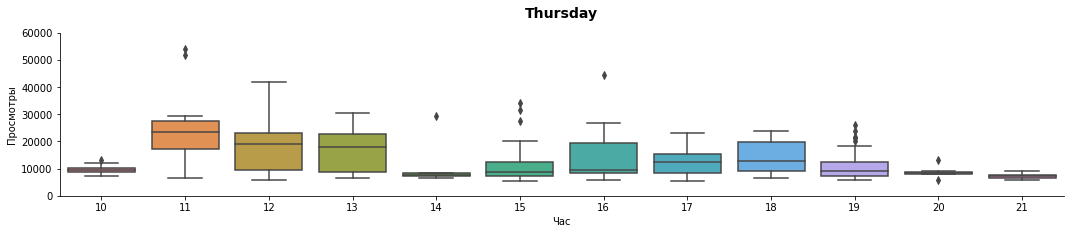

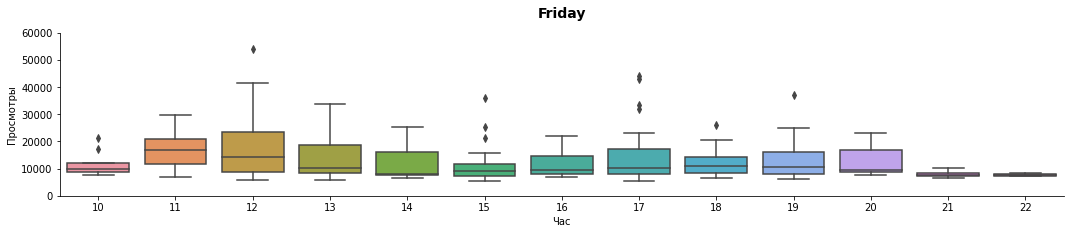

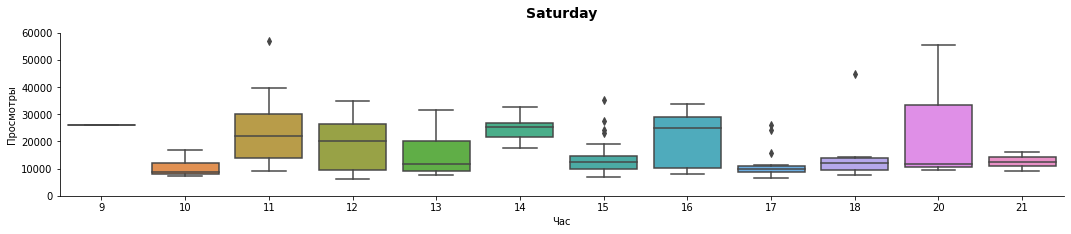

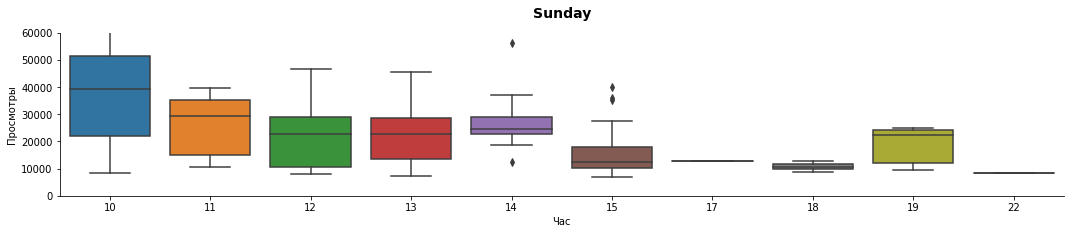

In [86]:
for day in day_order:
    plt.subplots(figsize=(18, 3))

    plt.title(f'{day}', fontsize=14, pad=15, fontweight='bold')
    sns.boxplot(x='hour', y='views.count', data=df[df['day_of_week_lit'] == day])
    sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    plt.ylim([0, 60000])
    plt.ylabel('Просмотры', fontsize=10)
    plt.xlabel('Час', fontsize=10)
    plt.show()

### 8. Выделение постов по тематикам 
***

Для анализа постов по тематикам, вычленим из постов теги. Найдем самые популярные и проведем анализ по интересующим тематикам.

In [87]:
# Приводим все слова в постах к нижнему регистру
df['text'] = df['text'].apply(lambda x: x.lower())

In [88]:
# Ищем теги
df['tags'] = df['text'].apply(lambda x: re.findall(r'[#]([а-я,a-z]\w+[а-я,a-z])@skillbox|[#_]([а-я]\w+[а-я])', x))

In [89]:
# Функция для пост обработки результата поисков тегов регулярным выражением.
def clean(some_str):
    list = []
    if some_str != None:
        
        for i in range(len(some_str)):
            if some_str[i] != None:
                
                for j in range(len(some_str[i])):
                    if some_str[i][j] != "":
                        list.append(some_str[i][j].replace('_', ' '))
    return list            

In [90]:
# Обрабатываем теги кастомной функцией
df['tags'] = df['tags'].apply(lambda x: clean(x))

# Удаляем пустые списки, посты без тегов
df['tags'] = df['tags'].apply(lambda x: x if x != [] else None)

Посколько часть постов с тегами на английском, переведем их на русский, чтобы обобщить результаты.

**Здесь я хотел сделать перевод, но так и не победил гугл ((**
***

In [91]:
# Функция для перевода
#def translate(some_list):
#    transated = []
#    if some_list != None:
#
#        for i in range(len(some_list)):
#            if some_list[i] != None:
#                translator= googletrans.Translator()
#                result = translator.translate(some_list[i], dest="russian")
#                transated.append(result.text)
#    return transated

In [92]:
#df['tags_translated'] = df['tags'].apply(lambda x: translate(x))

***

In [93]:
# Размножаем посты с тегами, чтобы осуществить поиск по вхождению тегов
tags_frame = df['tags'].apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('tags_sep')

tags_df = pd.merge(df, tags_frame, left_index=True, right_index=True)

tags_df.head(3)

,date,text,attachments,post_source.type,comments.count,likes.count,reposts.count,views.count,Time,year,month,day_of_week,hour,Y_M,activity,conversy,day_of_week_lit,tags,tags_sep
18,2020-09-30 15:00:09,комментировать свой код — обязательный навык п...,"[{'type': 'link', 'link': {'url': 'https://ski...",api,4,22,3,16371,2020-09-30 18:00:09,2020,9,2,18,2020-Sep,29,0.177143,Wednesday,"[статья, программирование]",статья
18,2020-09-30 15:00:09,комментировать свой код — обязательный навык п...,"[{'type': 'link', 'link': {'url': 'https://ski...",api,4,22,3,16371,2020-09-30 18:00:09,2020,9,2,18,2020-Sep,29,0.177143,Wednesday,"[статья, программирование]",программирование
19,2020-09-30 08:15:31,почему отделам маркетинга и продаж не всегда п...,"[{'type': 'photo', 'photo': {'album_id': -7, '...",api,2,49,8,16815,2020-09-30 11:15:31,2020,9,2,11,2020-Sep,59,0.350877,Wednesday,"[совет препода, маркетинг]",совет препода


Найдем ТОП упоминаний по тегам.

In [94]:
tags_frame['count'] = 1

tags_frame = tags_frame.groupby(['tags_sep']).agg({'count' : 'sum'}).reset_index().sort_values(by=['count'], ascending=False)

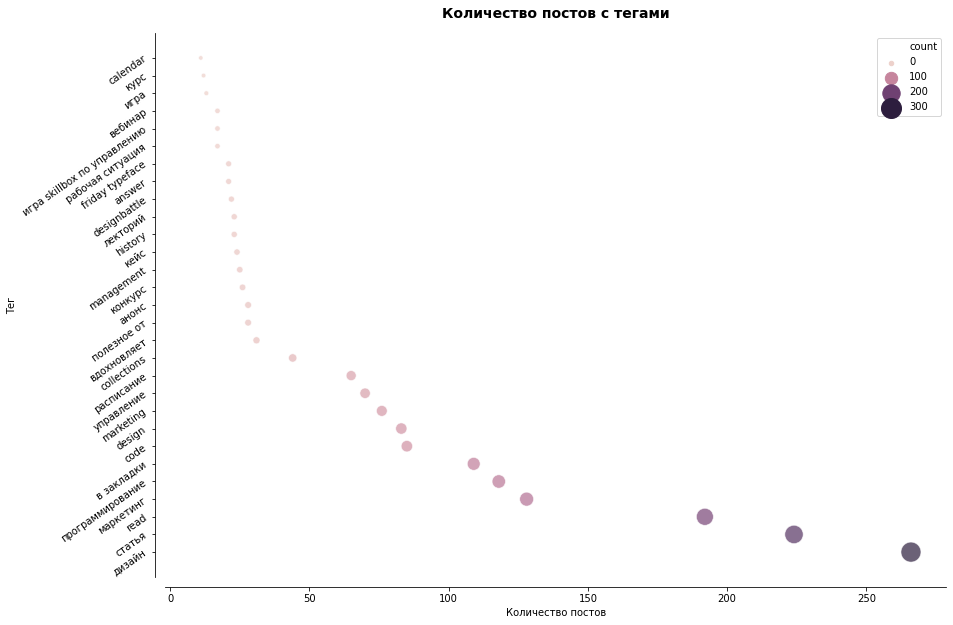

In [95]:
plt.subplots(figsize=(14, 10))
gr = sns.scatterplot(x='count', y="tags_sep", hue="count", data=tags_frame[tags_frame['count'] > 10], 
                alpha=0.7, 
                size="count", 
                sizes=(20, 400))
sns.despine(offset=10)
plt.title('Количество постов с тегами', fontsize=14, pad=15, fontweight='bold')
plt.yticks(rotation=35)
plt.ylabel('Тег', fontsize=10)
plt.xlabel('Количество постов', fontsize=10)
plt.show()

### 9. Программирование 
***

Рассмотрим публикации по программированию.

In [96]:
programming = tags_df[(tags_df['tags_sep'] == 'программирование') | (tags_df['tags_sep'] == 'code')]

In [97]:
df_prog_grouped = programming.groupby(['Y_M', 'year', 'month']).agg({'text' : 'count'}).reset_index()\
    .sort_values(by=['year', 'month'])

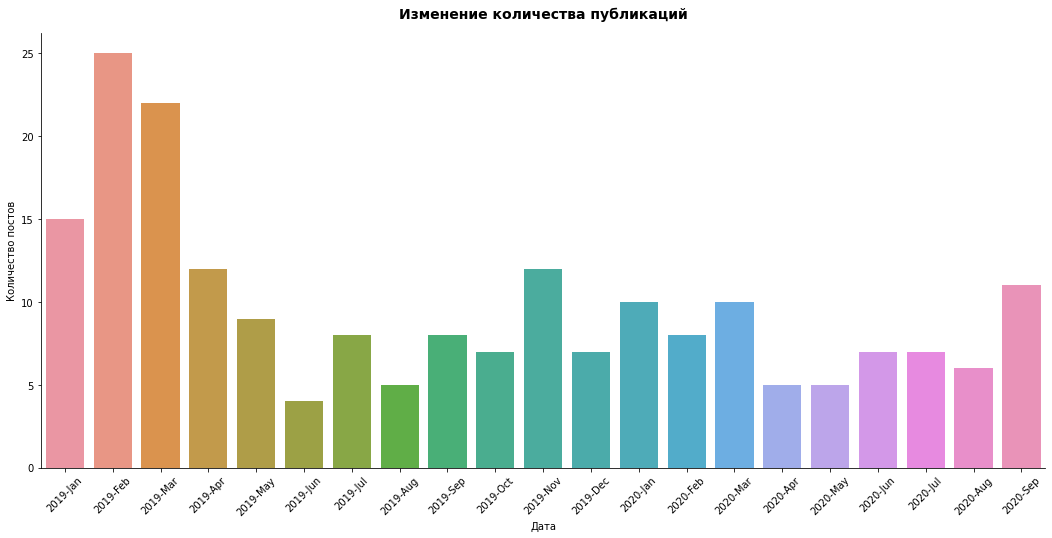

In [98]:
plt.subplots(figsize=(18, 8))

plt.title('Изменение количества публикаций', fontsize=14, pad=15, fontweight='bold')
gr = sns.barplot(x='Y_M', y='text', data=df_prog_grouped)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylabel('Количество постов', fontsize=10)
plt.xlabel('Дата', fontsize=10)
gr.set_xticklabels(gr.get_xticklabels(), rotation=45)
plt.show()

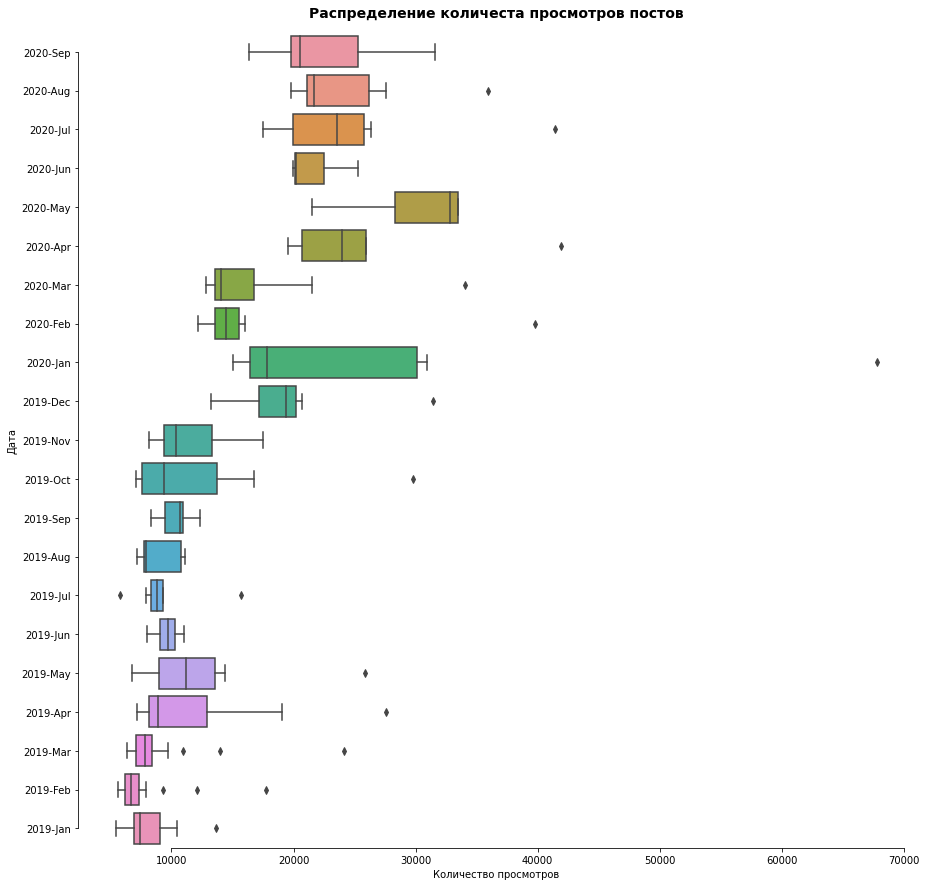

In [99]:
plt.subplots(figsize=(15, 15))
plt.title('Распределение количеста просмотров постов', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='views.count', y='Y_M', data=programming)
plt.xlabel('Количество просмотров', fontsize=10)
plt.ylabel('Дата', fontsize=10)
sns.despine(offset=0, trim=True)

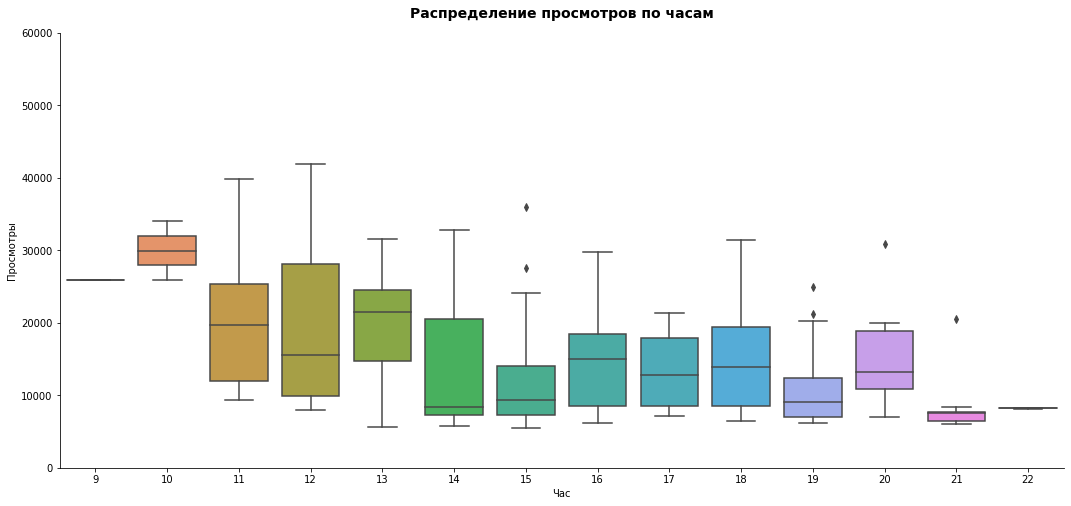

In [100]:
plt.subplots(figsize=(18, 8))

plt.title('Распределение просмотров по часам', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='hour', y='views.count', data=programming)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylim([0, 60000])
plt.ylabel('Просмотры', fontsize=10)
plt.xlabel('Час', fontsize=10)
plt.show()

### 10. Конкурсы 
***

Рассмотрим публикации с конкурсами.

In [101]:
prizes = tags_df[(tags_df['tags_sep'] == 'конкурс')]

In [102]:
df_prizes_grouped = prizes.groupby(['Y_M', 'year', 'month']).agg({'text' : 'count'}).reset_index()\
    .sort_values(by=['year', 'month'])

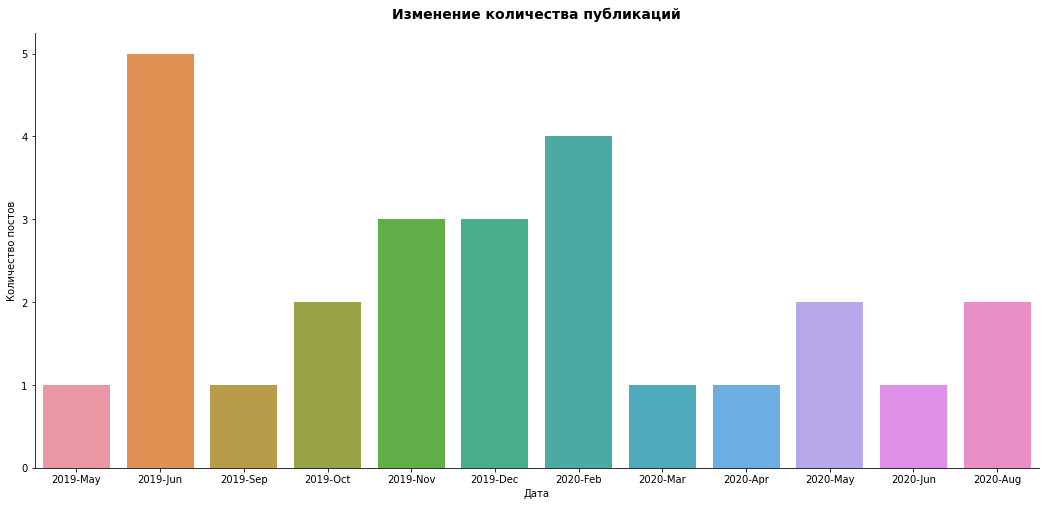

In [103]:
plt.subplots(figsize=(18, 8))

plt.title('Изменение количества публикаций', fontsize=14, pad=15, fontweight='bold')
gr = sns.barplot(x='Y_M', y='text', data=df_prizes_grouped)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylabel('Количество постов', fontsize=10)
plt.xlabel('Дата', fontsize=10)
plt.show()

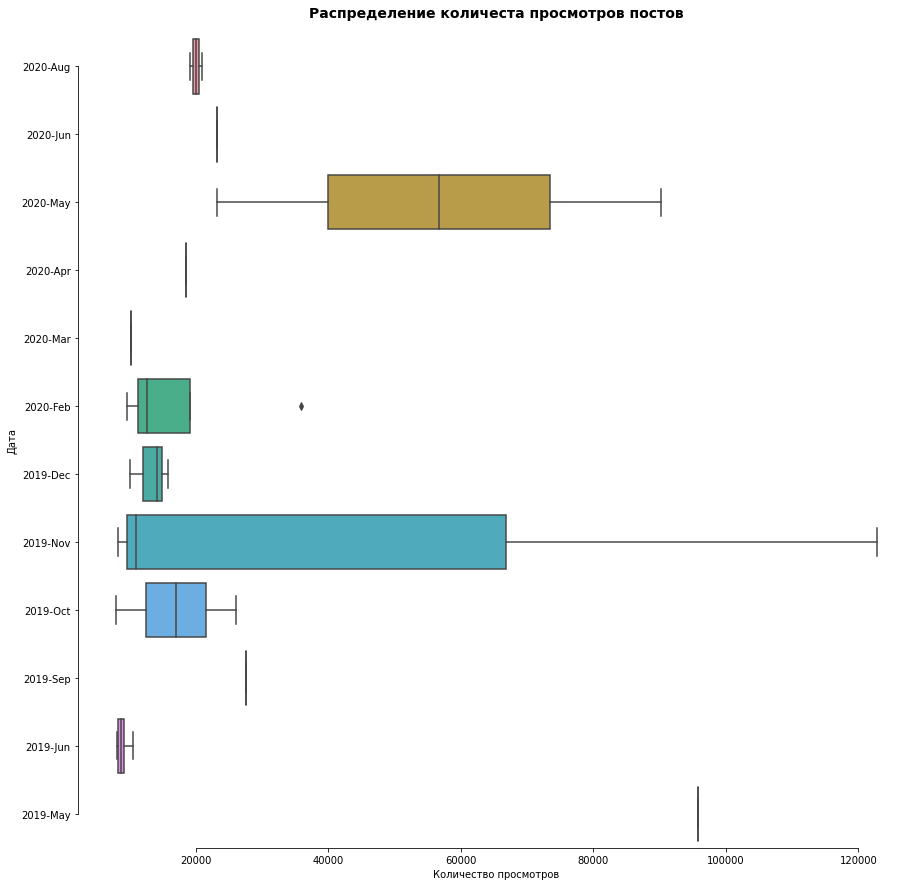

In [104]:
plt.subplots(figsize=(15, 15))
plt.title('Распределение количеста просмотров постов', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='views.count', y='Y_M', data=prizes)
plt.xlabel('Количество просмотров', fontsize=10)
plt.ylabel('Дата', fontsize=10)
sns.despine(offset=0, trim=True)

### 11. Распределение просмотров и активностей по тегам 
***

In [105]:
def bad_translation(word):
    if word == 'marketing':
        return 'маркетинг'
    elif word == 'management':
        return 'управление' 
    elif word == 'design':
        return 'дизайн'
    elif word == 'read':
        return 'статья'  
    elif word == 'code':
        return 'программирование'
    else:
        return word

In [106]:
tags_df['my_en_bad'] = tags_df['tags_sep'].apply(lambda x: bad_translation(x))

tags_frame_en = tags_df.groupby(['my_en_bad']).agg({'text' : 'count'})\
    .reset_index()\
    .sort_values(by=['text'], ascending=False)

mask = tags_frame_en.head(10)

tags_dep = pd.merge(left=tags_df, right=mask, left_on='my_en_bad', right_on='my_en_bad')

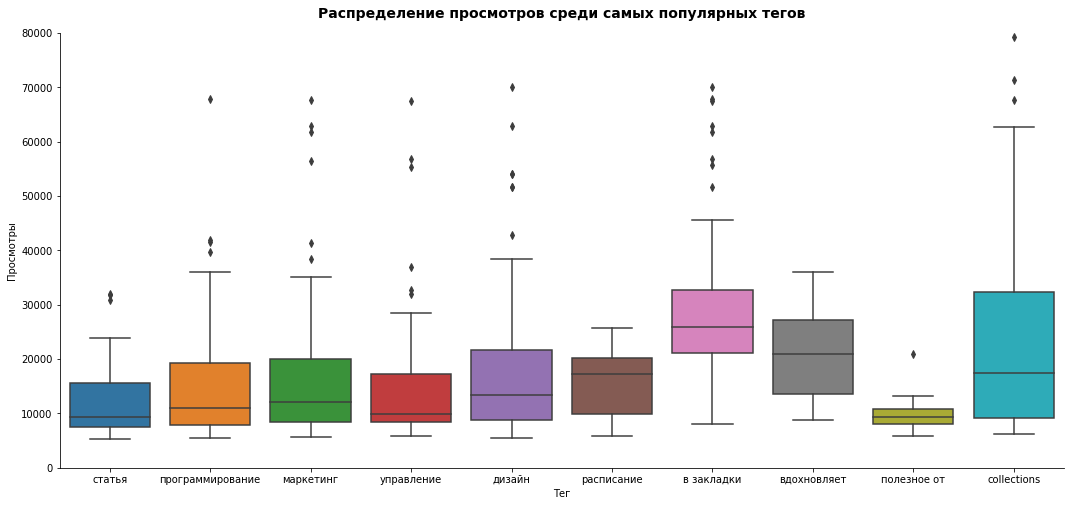

In [109]:
plt.subplots(figsize=(18, 8))

plt.title('Распределение просмотров среди самых популярных тегов', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='my_en_bad', y='views.count', data=tags_dep)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylim([0, 80000])
plt.ylabel('Просмотры', fontsize=10)
plt.xlabel('Тег', fontsize=10)
plt.show()

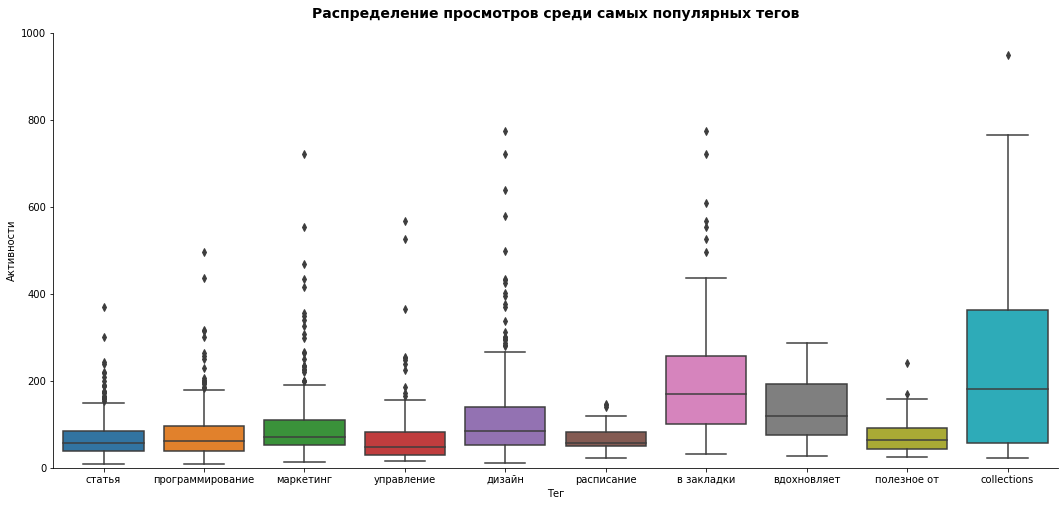

In [108]:
plt.subplots(figsize=(18, 8))

plt.title('Распределение просмотров среди самых популярных тегов', fontsize=14, pad=15, fontweight='bold')
sns.boxplot(x='my_en_bad', y='activity', data=tags_dep)
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.ylim([0, 1000])
plt.ylabel('Активности', fontsize=10)
plt.xlabel('Тег', fontsize=10)
plt.show()